In [85]:
# ------------------ SETUP FOR COLAB ------------------
!pip install --quiet pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ------------------ CONFIG ------------------
n_current_delays = 2
n_voltage_delays = 4
hidden_size = 64
num_layers = 1
learning_rate = 0.001
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ------------------ LOAD DATA ------------------
# ⚠️ Replace this path with your actual file upload or Google Drive mount
from google.colab import files
# ------------------ LOAD DATA ------------------
data = pd.read_csv("/content/Combined_train_Data.csv")
voltage = data['Voltage_V'].values
current = data['Current_A'].values


# ------------------ BUILD NARX INPUT ------------------
def build_narx_input(current, voltage, n_current_delays, n_voltage_delays):
    X, y = [], []
    max_delay = max(n_current_delays, n_voltage_delays)
    for t in range(max_delay, len(current)):
        I_window = current[t - n_current_delays : t + 1][::-1]
        V_window = voltage[t - n_voltage_delays : t][::-1]
        x_input = np.concatenate([I_window, V_window])
        X.append(x_input)
        y.append(voltage[t])
    return np.array(X), np.array(y)

X_raw, y_raw = build_narx_input(current, voltage, n_current_delays, n_voltage_delays)

# ------------------ SCALE ------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1))

# ------------------ RESHAPE FOR RNN ------------------
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_scaled = y_scaled.reshape((-1, 1))

# ------------------ SPLIT & CONVERT TO TENSORS ------------------
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

✅ Using device: cuda


In [86]:
# ------------------ NARX RNN MODEL ------------------
# ------------------ IMPROVED NARX RNN MODEL ------------------
class NARX_RNN(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.2):
        super(NARX_RNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


model = NARX_RNN(input_size=X_train.shape[2]).to(device)

criterion = nn.SmoothL1Loss()  # better for noisy output
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## NN TRAINING

In [87]:
# ------------------ TRAIN ------------------
criterion = nn.SmoothL1Loss()  # more robust to outliers than MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()

    # Gradient clipping (optional but useful for RNNs)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f}")


Epoch 000 | Train Loss: 0.34761 | Val Loss: 0.25054
Epoch 010 | Train Loss: 0.13014 | Val Loss: 0.07366
Epoch 020 | Train Loss: 0.02051 | Val Loss: 0.00186
Epoch 030 | Train Loss: 0.01728 | Val Loss: 0.01694
Epoch 040 | Train Loss: 0.01377 | Val Loss: 0.00872
Epoch 050 | Train Loss: 0.01064 | Val Loss: 0.00144
Epoch 060 | Train Loss: 0.01046 | Val Loss: 0.00132
Epoch 070 | Train Loss: 0.00943 | Val Loss: 0.00279
Epoch 080 | Train Loss: 0.00899 | Val Loss: 0.00290
Epoch 090 | Train Loss: 0.00842 | Val Loss: 0.00195
Epoch 100 | Train Loss: 0.00791 | Val Loss: 0.00178
Epoch 110 | Train Loss: 0.00741 | Val Loss: 0.00188
Epoch 120 | Train Loss: 0.00690 | Val Loss: 0.00165
Epoch 130 | Train Loss: 0.00640 | Val Loss: 0.00142
Epoch 140 | Train Loss: 0.00592 | Val Loss: 0.00131
Epoch 150 | Train Loss: 0.00543 | Val Loss: 0.00115
Epoch 160 | Train Loss: 0.00500 | Val Loss: 0.00098
Epoch 170 | Train Loss: 0.00455 | Val Loss: 0.00084
Epoch 180 | Train Loss: 0.00414 | Val Loss: 0.00070
Epoch 190 | 


🔍 RMSE on validation set: 0.0102 V


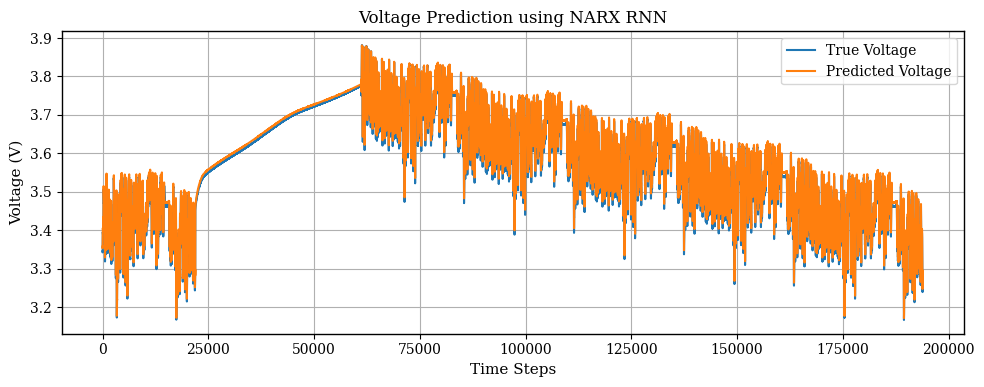

In [88]:
# ------------------ EVALUATION ------------------
model.eval()
with torch.no_grad():
    y_val_pred_scaled = model(X_val_tensor).cpu().numpy()
    y_val_true_scaled = y_val_tensor.cpu().numpy()

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_true_scaled)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"\n🔍 RMSE on validation set: {rmse:.4f} V")

# ------------------ PLOTTING ------------------
plt.figure(figsize=(10, 4))
plt.plot(y_val_true, label="True Voltage")
plt.plot(y_val_pred, label="Predicted Voltage")
plt.title("Voltage Prediction using NARX RNN")
plt.xlabel("Time Steps")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test Dataset


🧪 Test Set Evaluation (Normalized):
  RMSE : 0.01100
  R²   : 0.97669


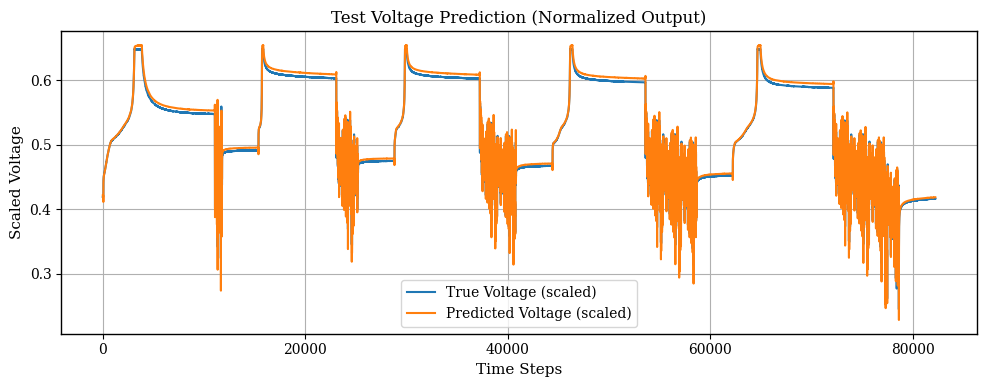

In [107]:
test_df = pd.read_excel("Merged_test_Data.xlsx", engine="openpyxl")
current_test = test_df['Current_A'].values
voltage_test = test_df['Voltage_V'].values
time_test = test_df['Test_Time_s'].values if 'Test_Time_s' in test_df.columns else np.arange(len(voltage_test))

X_test_raw, y_test_raw = build_narx_input(current_test, voltage_test, n_current_delays, n_voltage_delays)

X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_test_scaled = y_test_scaled.reshape((-1, 1))

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# ------------------ EVALUATE ON TEST ------------------
model.eval()
with torch.no_grad():
    y_pred_test_scaled = model(X_test_tensor).cpu().numpy()
    y_true_test_scaled = y_test_tensor.cpu().numpy()

rmse_test = np.sqrt(mean_squared_error(y_true_test_scaled, y_pred_test_scaled))
r2_test = r2_score(y_true_test_scaled, y_pred_test_scaled)
true_V_denorm = scaler_y.inverse_transform(y_true_test_scaled)
pred_V_denorm = scaler_y.inverse_transform(y_pred_test_scaled)


print(f"\n🧪 Test Set Evaluation (Normalized):")
print(f"  RMSE : {rmse_test:.5f}")
print(f"  R²   : {r2_test:.5f}")

# ------------------ PLOT ------------------
plt.figure(figsize=(10, 4))
plt.plot(y_true_test_scaled, label='True Voltage (scaled)')
plt.plot(y_pred_test_scaled, label='Predicted Voltage (scaled)')
plt.title("Test Voltage Prediction (Normalized Output)")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ FINAL OUTPUTS (Renamed) ------------------
narx_true = true_V_denorm.flatten()
narx_pred = pred_V_denorm.flatten()
narx_time = time_test[max(n_current_delays, n_voltage_delays):]

In [108]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import zipfile

def plot_voltage_denorm_metrics(
    true_voltage, preds,
    region_start_idx, region_end_idx, title_prefix="",
    model=None,                        # <--- Pass model here
    model_save_dir=".",
    metrics_excel_path="narx_metrics_log.xlsx",
    zip_name="narx_outputs.zip",
    download_zip=True):

    # --- Extract Region ---
    true_dyn = true_voltage[region_start_idx:region_end_idx + 1]
    pred_dyn = preds[region_start_idx:region_end_idx + 1]
    time_rel = np.arange(1, len(true_dyn) + 1)

    # --- Metrics ---
    rmse = np.sqrt(mean_squared_error(true_dyn, pred_dyn))
    mae = mean_absolute_error(true_dyn, pred_dyn)
    nrmse = rmse / (np.max(true_dyn) - np.min(true_dyn))
    r2 = r2_score(true_dyn, pred_dyn)

    print(f"\n📊 {title_prefix} Metrics (Indices {region_start_idx}-{region_end_idx}):")
    print(f"  RMSE   : {rmse:.4f} V")
    print(f"  MAE    : {mae:.4f} V")
    print(f"  NRMSE  : {nrmse:.4f}")
    print(f"  R²     : {r2:.4f}")

    # --- Save metrics to Excel ---
    metrics_row = {
        "Title": title_prefix,
        "Index Start": region_start_idx,
        "Index End": region_end_idx,
        "RMSE (V)": rmse,
        "MAE (V)": mae,
        "NRMSE": nrmse,
        "R2 Score": r2
    }
    if os.path.exists(metrics_excel_path):
        df_existing = pd.read_excel(metrics_excel_path)
        df_out = pd.concat([df_existing, pd.DataFrame([metrics_row])], ignore_index=True)
    else:
        df_out = pd.DataFrame([metrics_row])
    df_out.to_excel(metrics_excel_path, index=False)

    # --- Plot Style ---
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 11,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 1.0
    })

    safe_title = title_prefix.replace(" ", "_").replace("-", "_")
    voltage_path = f"{safe_title}_voltage_{region_start_idx}_{region_end_idx}.pdf"
    model_path = os.path.join(model_save_dir, f"{safe_title}_model.pt")

    # --- Voltage Plot ---
    fig, ax = plt.subplots(figsize=(6.5, 3.2))
    ax.plot(time_rel, true_dyn, label='True', color='black', linewidth=1.2)
    ax.plot(time_rel, pred_dyn, '--', label='Prediction', color='tab:red', linewidth=1.2)
    ax.set_title(title_prefix)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Voltage [V]")
    ax.legend(loc='upper right', frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', length=5, width=1)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(voltage_path, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Save the model if provided ---
    if model is not None:
        torch.save(model.state_dict(), model_path)
        print(f"💾 Model saved to: {model_path}")

    # --- Zip Results ---
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        zipf.write(voltage_path)
        zipf.write(metrics_excel_path)
        if model is not None:
            zipf.write(model_path)

    print(f"\n🗜️  Created ZIP: {zip_name}")

    # --- Trigger download in Colab ---
    if download_zip:
        try:
            from google.colab import files
            files.download(zip_name)
        except:
            print("💡 Not running in Colab or download failed.")

    return zip_name



📊 Transient Dynamics Metrics (Indices 72500-74000):
  RMSE   : 0.0364 V
  MAE    : 0.0259 V
  NRMSE  : 0.1102
  R²     : 0.6033


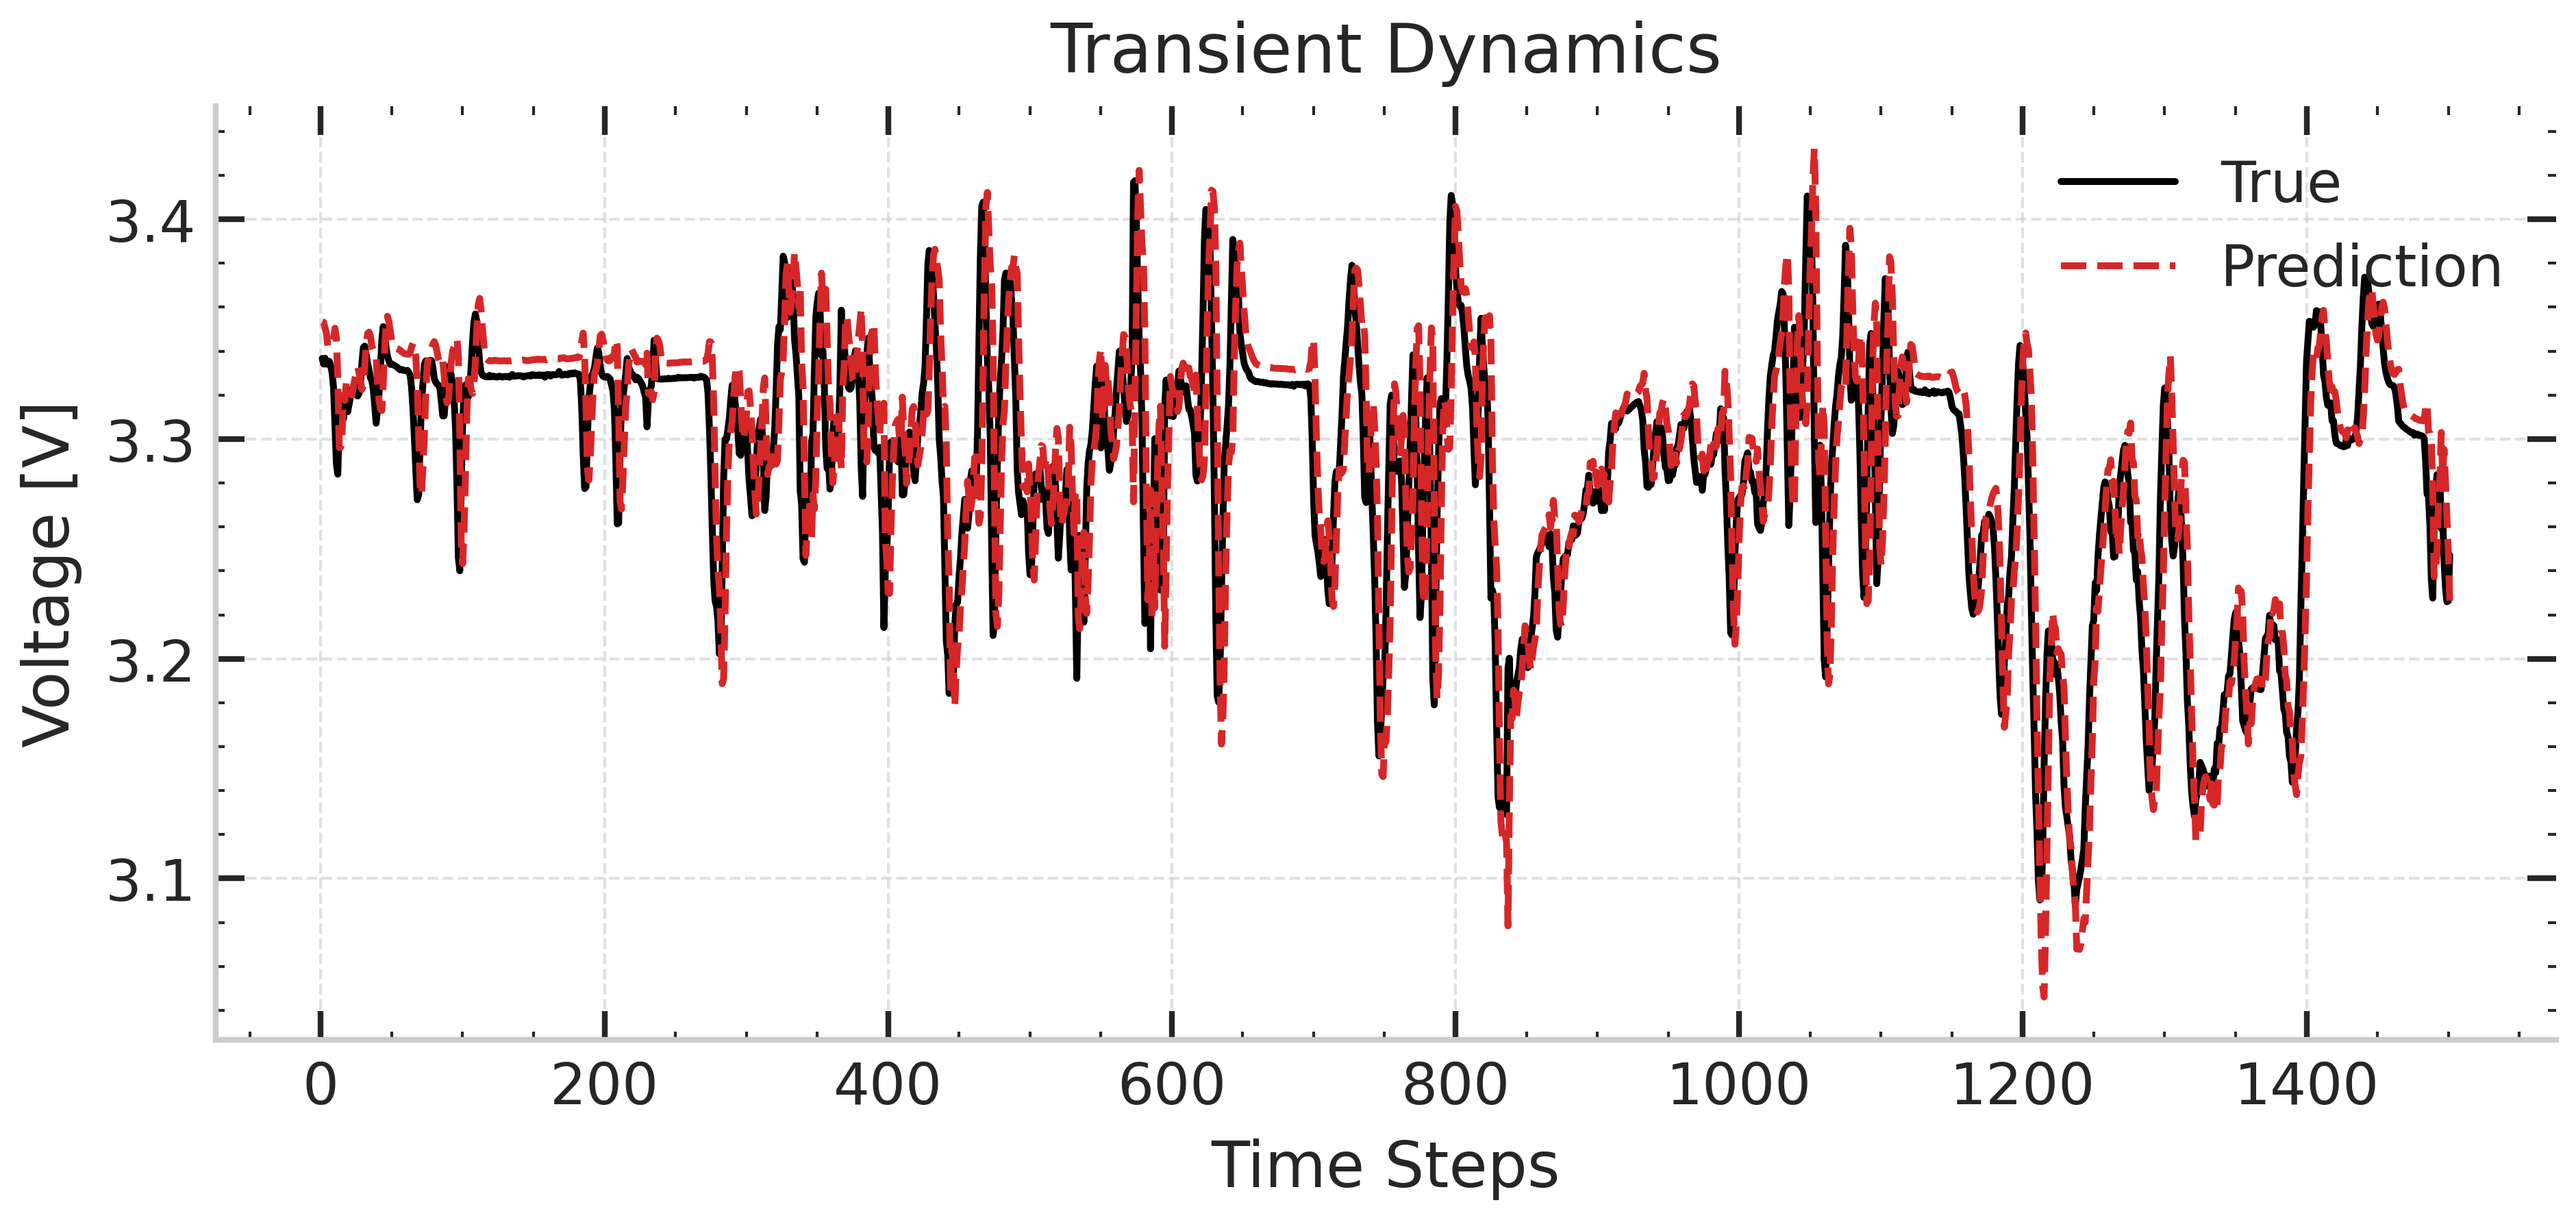

💾 Model saved to: ./Transient_Dynamics_model.pt

🗜️  Created ZIP: narx_transient.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 Steady State Dynamics Metrics (Indices 62000-66000):
  RMSE   : 0.0063 V
  MAE    : 0.0047 V
  NRMSE  : 0.0187
  R²     : 0.9953


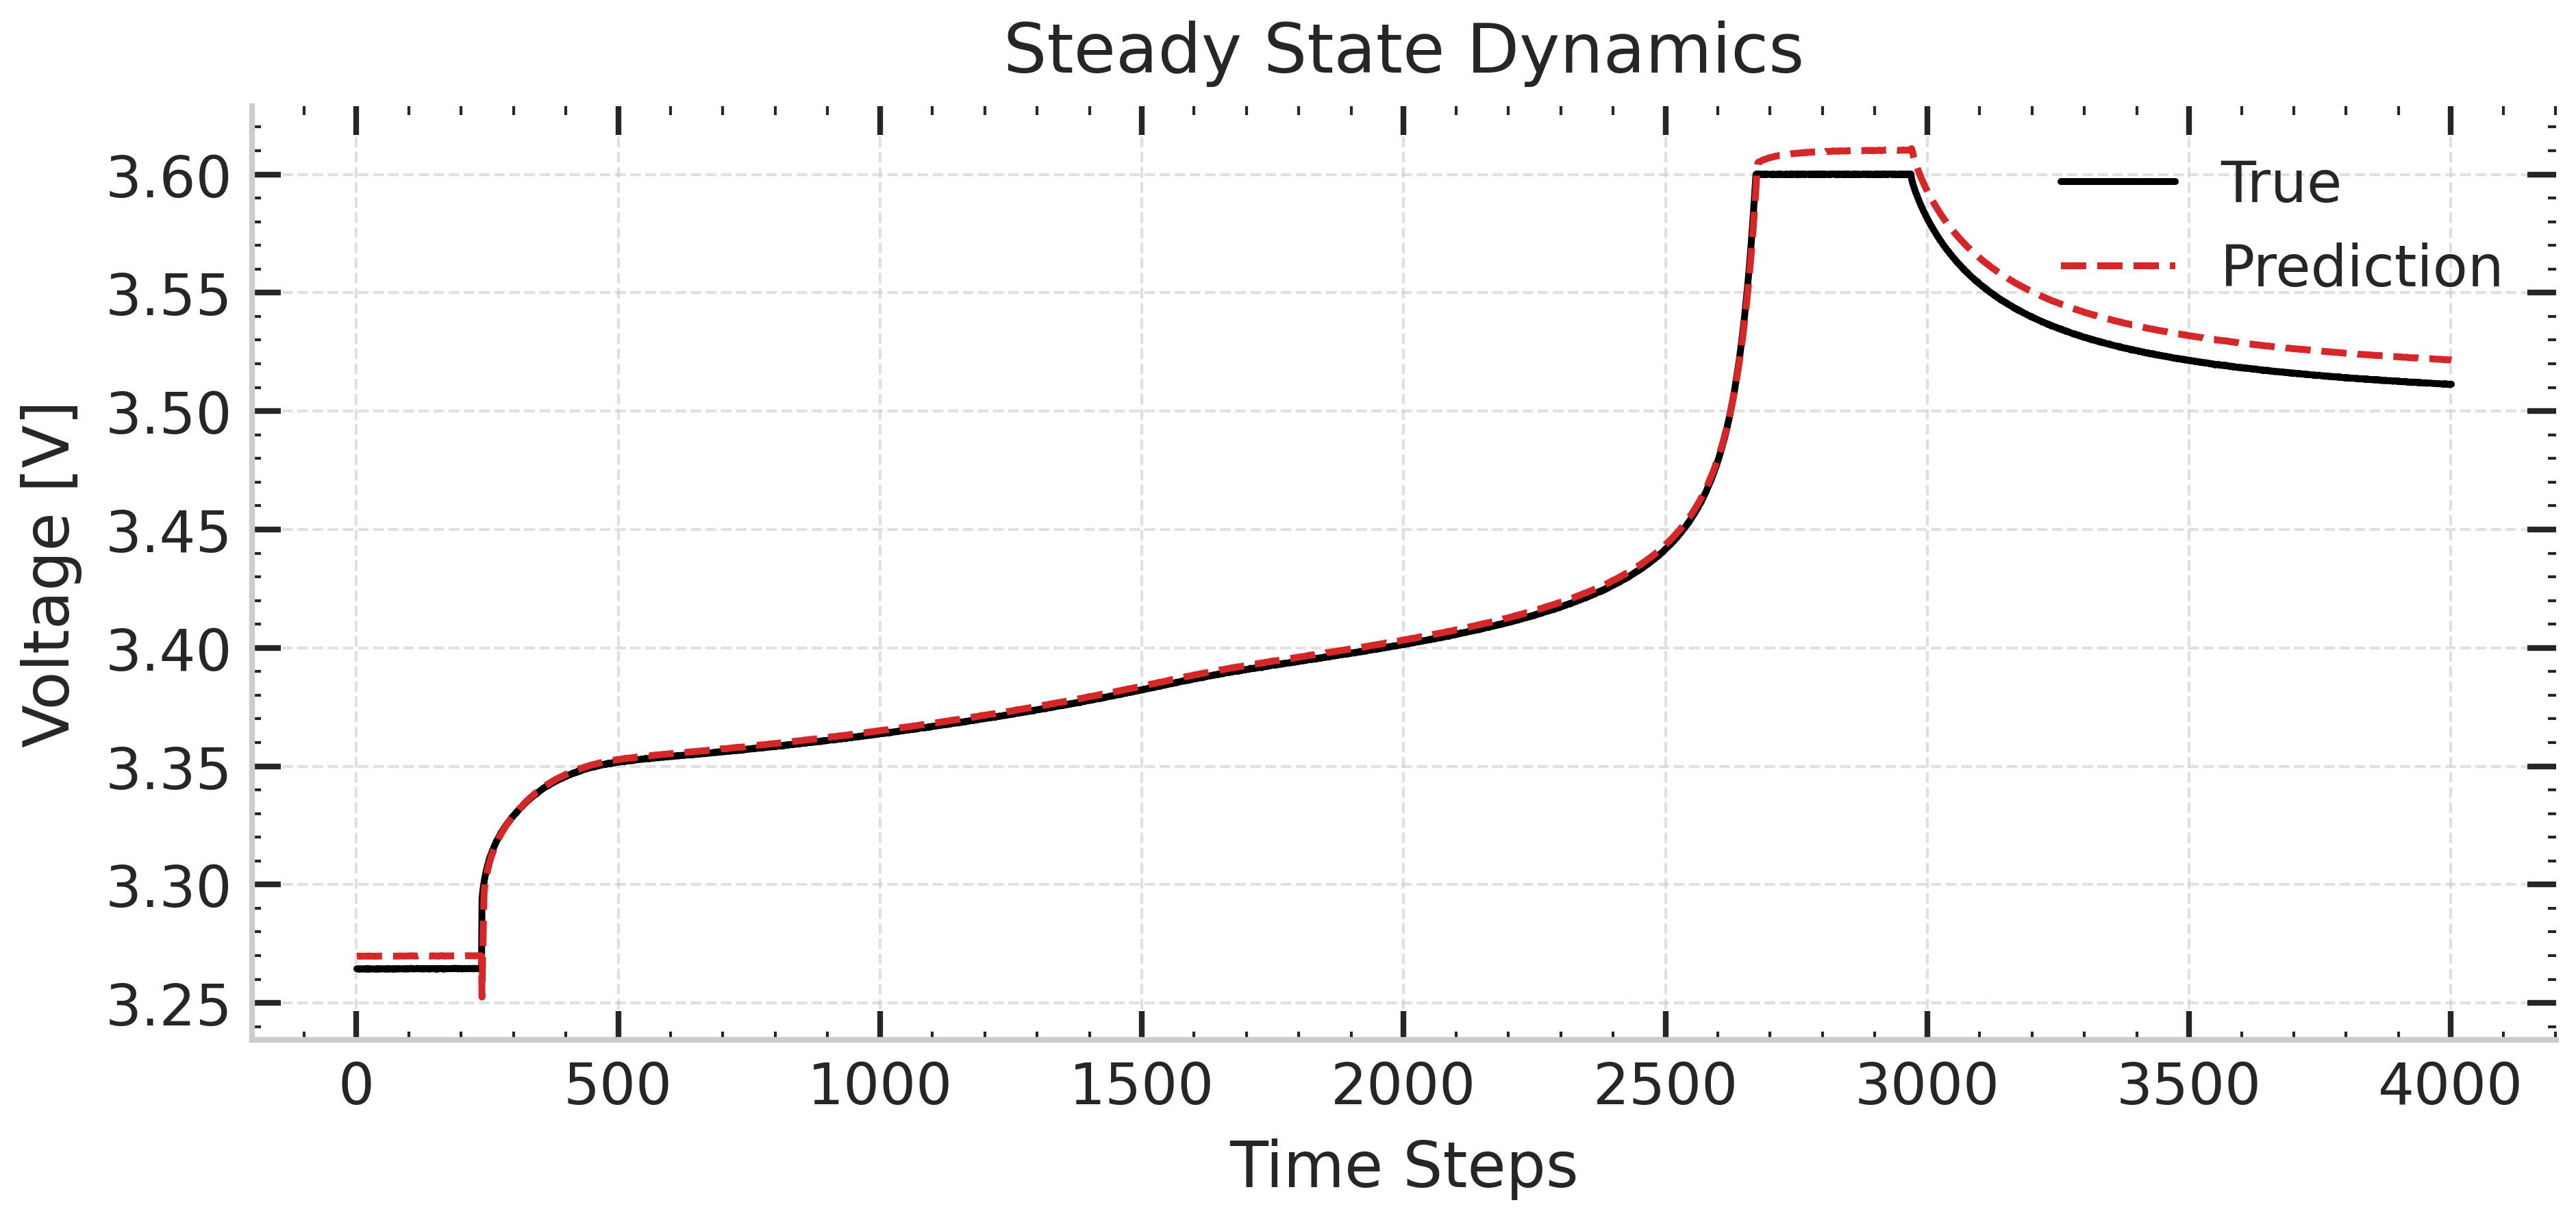

💾 Model saved to: ./Steady_State_Dynamics_model.pt

🗜️  Created ZIP: narx_SS.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'narx_SS.zip'

In [191]:
start_time = 72500
end_time = 74000
plot_voltage_denorm_metrics(
    true_voltage=narx_true,
    preds=narx_pred,
    region_start_idx=start_time,
    region_end_idx=end_time,
    title_prefix="Transient Dynamics",
    model=model,  # <-- include trained model here
    zip_name="narx_transient.zip"
)

start_time = 62000
end_time = 66000
plot_voltage_denorm_metrics(
    true_voltage=narx_true,
    preds=narx_pred,
    region_start_idx=start_time,
    region_end_idx=end_time,
    title_prefix="Steady State Dynamics",
    model=model,  # <-- include trained model here,
    zip_name="narx_SS.zip"
)




# DEEP KOOPMAN OPERATOR

Epoch 0: Loss = 2.0905
Epoch 100: Loss = 0.0700
Epoch 200: Loss = 0.0062
Epoch 300: Loss = 0.0020
Epoch 400: Loss = 0.0012
Epoch 500: Loss = 0.0009
Epoch 600: Loss = 0.0007
Epoch 700: Loss = 0.0006
Epoch 800: Loss = 0.0006
Epoch 900: Loss = 0.0005
RMSE: 0.02106470579854411


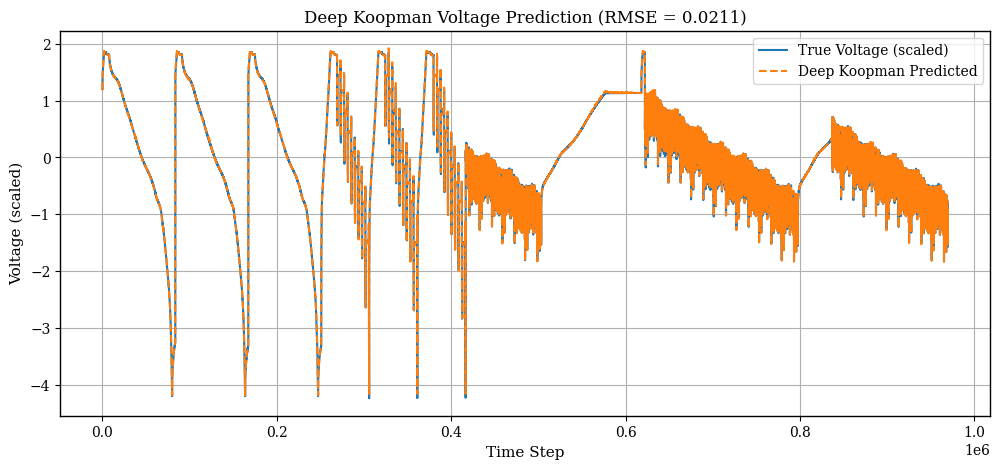

In [115]:
# ------------------- KOOPMAN: IMPORTS -------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- KOOPMAN: LOAD DATA -------------------
file_path = "/content/Combined_train_Data.csv"
data_koopman = pd.read_csv(file_path)
voltage_koopman = data_koopman['Voltage_V'].values
current_koopman = data_koopman['Current_A'].values

# ------------------- KOOPMAN: BUILD DATA -------------------
def build_data(voltage, current, delay=2):
    X, Y, U = [], [], []
    for t in range(delay, len(voltage) - 1):
        x_t = voltage[t - delay + 1: t + 1][::-1]
        x_tp1 = voltage[t - delay + 2: t + 2][::-1]
        u_t = [current[t]]
        X.append(x_t)
        Y.append(x_tp1)
        U.append(u_t)
    return np.array(X), np.array(Y), np.array(U)

n_voltage_delays = 4
X_koopman_raw, Y_koopman_raw, U_koopman_raw = build_data(voltage_koopman, current_koopman, delay=n_voltage_delays)

# ------------------- KOOPMAN: SCALING -------------------
scaler_X_koopman = StandardScaler()
scaler_Y_koopman = StandardScaler()
scaler_U_koopman = StandardScaler()

X_koopman_scaled = scaler_X_koopman.fit_transform(X_koopman_raw)
Y_koopman_scaled = scaler_Y_koopman.fit_transform(Y_koopman_raw)
U_koopman_scaled = scaler_U_koopman.fit_transform(U_koopman_raw)

X_koopman_tensor = torch.tensor(X_koopman_scaled, dtype=torch.float32).to(device)
Y_koopman_tensor = torch.tensor(Y_koopman_scaled, dtype=torch.float32).to(device)
U_koopman_tensor = torch.tensor(U_koopman_scaled, dtype=torch.float32).to(device)

# ------------------- NETWORK ARCHITECTURE -------------------
latent_dim = 4
input_dim = X_tensor.shape[1]
control_dim = U_tensor.shape[1]

class DeepKoopman(nn.Module):
    def __init__(self, input_dim, latent_dim, control_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
        self.B = nn.Linear(control_dim, latent_dim, bias=False)
        self.K = nn.Linear(latent_dim, latent_dim, bias=False)

    def forward(self, x, u):
        z = self.encoder(x)
        z_next = self.K(z) + self.B(u)
        x_recon = self.decoder(z)
        x_pred = self.decoder(z_next)
        return x_recon, x_pred, z, z_next

model = DeepKoopman(input_dim, latent_dim, control_dim).to(device)

# ------------------- TRAINING -------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    x_recon, x_pred, _, _ = model(X_tensor, U_tensor)
    loss = loss_fn(x_recon, X_tensor) + loss_fn(x_pred, Y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# ------------------- PREDICTION -------------------
model.eval()
_, preds, _, _ = model(X_tensor, U_tensor)
v_preds = preds[:, 0].detach().cpu().numpy()
v_true = Y_tensor[:, 0].cpu().numpy()

rmse = np.sqrt(mean_squared_error(v_true, v_preds))
print("RMSE:", rmse)

# ------------------- PLOT -------------------
plt.figure(figsize=(12, 5))
plt.plot(v_true[:], label="True Voltage (scaled)")
plt.plot(v_preds[:], '--', label="Deep Koopman Predicted")
plt.title(f"Deep Koopman Voltage Prediction (RMSE = {rmse:.4f})")
plt.xlabel("Time Step")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0: Loss = 2.0429
Epoch 100: Loss = 0.0475
Epoch 200: Loss = 0.0054
Epoch 300: Loss = 0.0019
Epoch 400: Loss = 0.0012
Epoch 500: Loss = 0.0009
Epoch 600: Loss = 0.0007
Epoch 700: Loss = 0.0006
Epoch 800: Loss = 0.0006
Epoch 900: Loss = 0.0005
Koopman RMSE: 0.023456679880717025


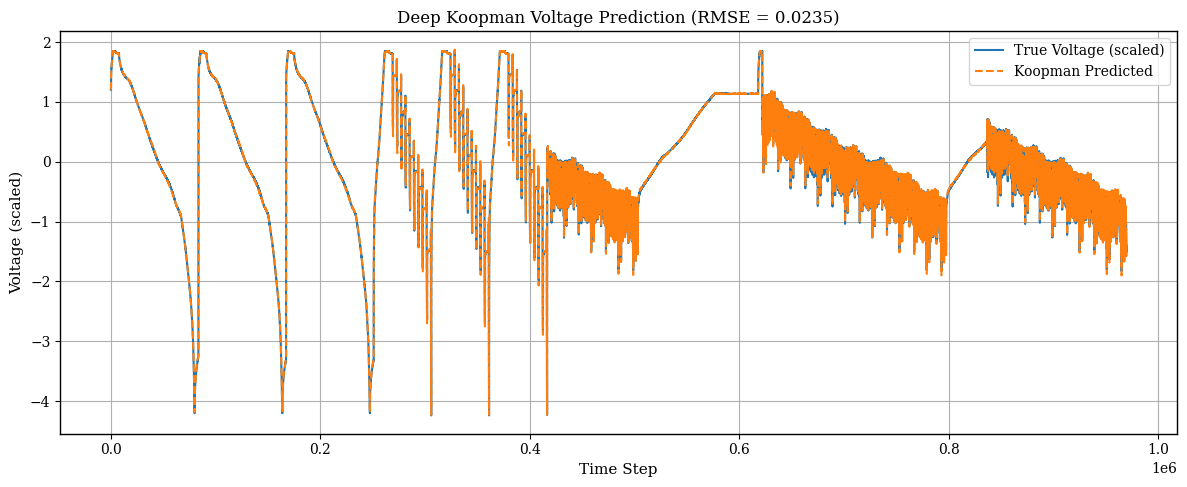

In [116]:
# ------------------- KOOPMAN: NETWORK ARCHITECTURE -------------------
latent_dim = 4
input_dim = X_koopman_tensor.shape[1]
control_dim = U_koopman_tensor.shape[1]

class DeepKoopman(nn.Module):
    def __init__(self, input_dim, latent_dim, control_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
        self.B = nn.Linear(control_dim, latent_dim, bias=False)
        self.K = nn.Linear(latent_dim, latent_dim, bias=False)

    def forward(self, x, u):
        z = self.encoder(x)
        z_next = self.K(z) + self.B(u)
        x_recon = self.decoder(z)
        x_pred = self.decoder(z_next)
        return x_recon, x_pred, z, z_next

model_koopman = DeepKoopman(input_dim, latent_dim, control_dim).to(device)

# ------------------- KOOPMAN: TRAINING -------------------
optimizer = torch.optim.Adam(model_koopman.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 1000
for epoch in range(n_epochs):
    model_koopman.train()
    optimizer.zero_grad()
    x_recon, x_pred, _, _ = model_koopman(X_koopman_tensor, U_koopman_tensor)
    loss = loss_fn(x_recon, X_koopman_tensor) + loss_fn(x_pred, Y_koopman_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# ------------------- KOOPMAN: PREDICTION -------------------
model_koopman.eval()
with torch.no_grad():
    _, preds_koopman, _, _ = model_koopman(X_koopman_tensor, U_koopman_tensor)

v_preds_koopman = preds_koopman[:, 0].detach().cpu().numpy()
v_true_koopman = Y_koopman_tensor[:, 0].cpu().numpy()

rmse_koopman = np.sqrt(mean_squared_error(v_true_koopman, v_preds_koopman))
print("Koopman RMSE:", rmse_koopman)

# ------------------- KOOPMAN: PLOT -------------------
plt.figure(figsize=(12, 5))
plt.plot(v_true_koopman, label="True Voltage (scaled)")
plt.plot(v_preds_koopman, '--', label="Koopman Predicted")
plt.title(f"Deep Koopman Voltage Prediction (RMSE = {rmse_koopman:.4f})")
plt.xlabel("Time Step")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Koopman Test RMSE (denormalized): 0.0154 V


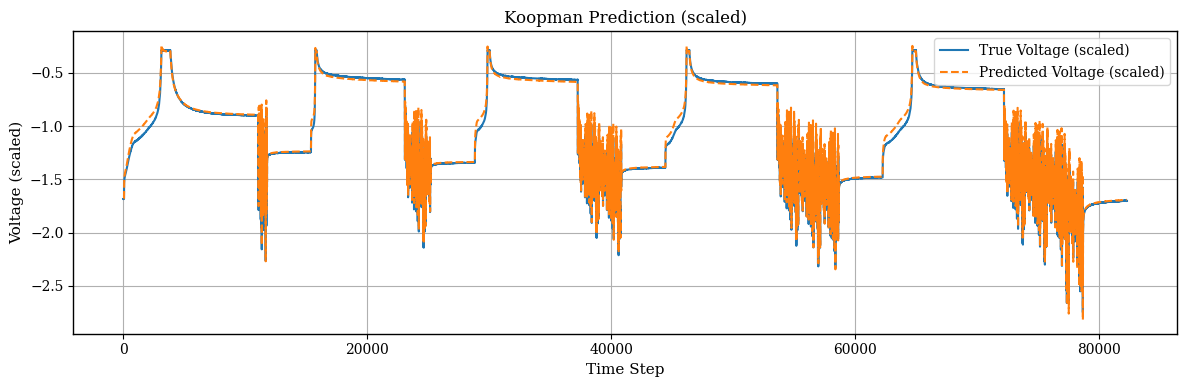

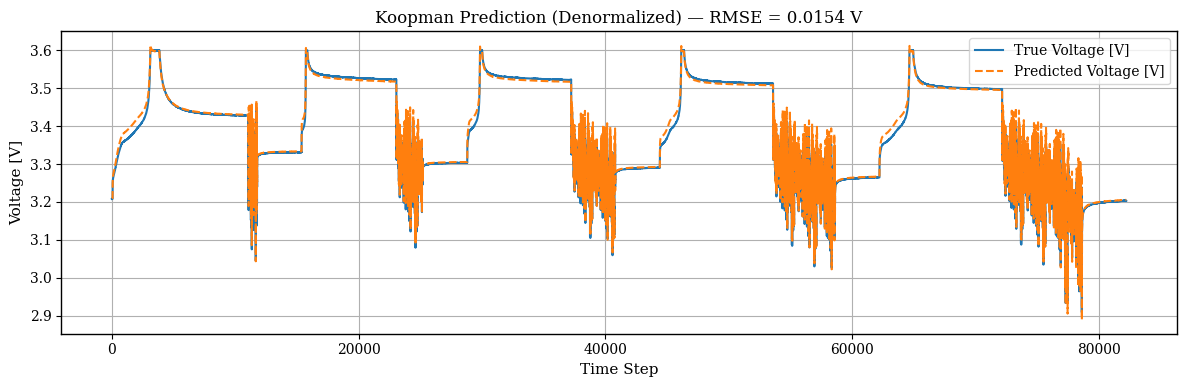

In [118]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ------------------ KOOPMAN: Load Test Data ------------------
test_df_koopman = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
voltage_test_koopman = test_df_koopman['Voltage_V'].values
current_test_koopman = test_df_koopman['Current_A'].values

# ------------------ KOOPMAN: Build Inputs ------------------
def build_test_data(voltage, current, delay=2):
    X, Y, U = [], [], []
    for t in range(delay, len(voltage) - 1):
        x_t = voltage[t - delay + 1: t + 1][::-1]
        x_tp1 = voltage[t - delay + 2: t + 2][::-1]
        u_t = [current[t]]
        X.append(x_t)
        Y.append(x_tp1)
        U.append(u_t)
    return np.array(X), np.array(Y), np.array(U)

X_koopman_test_raw, Y_koopman_test_raw, U_koopman_test_raw = build_test_data(
    voltage_test_koopman, current_test_koopman, delay=n_voltage_delays
)

# ------------------ KOOPMAN: Scale Using Training Scalers ------------------
X_koopman_test_scaled = scaler_X_koopman.transform(X_koopman_test_raw)
Y_koopman_test_scaled = scaler_Y_koopman.transform(Y_koopman_test_raw)
U_koopman_test_scaled = scaler_U_koopman.transform(U_koopman_test_raw)

X_koopman_test_tensor = torch.tensor(X_koopman_test_scaled, dtype=torch.float32).to(device)
Y_koopman_test_tensor = torch.tensor(Y_koopman_test_scaled, dtype=torch.float32).to(device)
U_koopman_test_tensor = torch.tensor(U_koopman_test_scaled, dtype=torch.float32).to(device)

# ------------------ KOOPMAN: Predict ------------------
model_koopman.eval()
with torch.no_grad():
    _, koopman_preds_test, _, _ = model_koopman(X_koopman_test_tensor, U_koopman_test_tensor)

v_preds_koopman_test_scaled = koopman_preds_test[:, 0].cpu().numpy()
v_actual_koopman_test_scaled = Y_koopman_test_tensor[:, 0].cpu().numpy()

# ------------------ KOOPMAN: Denormalize ------------------
koopman_pred = scaler_Y_koopman.inverse_transform(koopman_preds_test.cpu().numpy())[:, 0]
koopman_true = scaler_Y_koopman.inverse_transform(Y_koopman_test_tensor.cpu().numpy())[:, 0]

# ------------------ KOOPMAN: Evaluate ------------------
rmse_koopman_test = np.sqrt(mean_squared_error(koopman_true, koopman_pred))
print(f"\n🔍 Koopman Test RMSE (denormalized): {rmse_koopman_test:.4f} V")

# ------------------ KOOPMAN: Plot (scaled) ------------------
plt.figure(figsize=(12, 4))
plt.plot(v_actual_koopman_test_scaled, label="True Voltage (scaled)")
plt.plot(v_preds_koopman_test_scaled, '--', label="Predicted Voltage (scaled)")
plt.title("Koopman Prediction (scaled)")
plt.xlabel("Time Step")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ KOOPMAN: Plot (denormalized) ------------------
plt.figure(figsize=(12, 4))
plt.plot(koopman_true, label="True Voltage [V]")
plt.plot(koopman_pred, '--', label="Predicted Voltage [V]")
plt.title(f"Koopman Prediction (Denormalized) — RMSE = {rmse_koopman_test:.4f} V")
plt.xlabel("Time Step")
plt.ylabel("Voltage [V]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📊 Transient Dynamics Metrics (Indices 72500-74000):
  RMSE   : 0.0281 V
  MAE    : 0.0197 V
  NRMSE  : 0.0850
  R²     : 0.7639


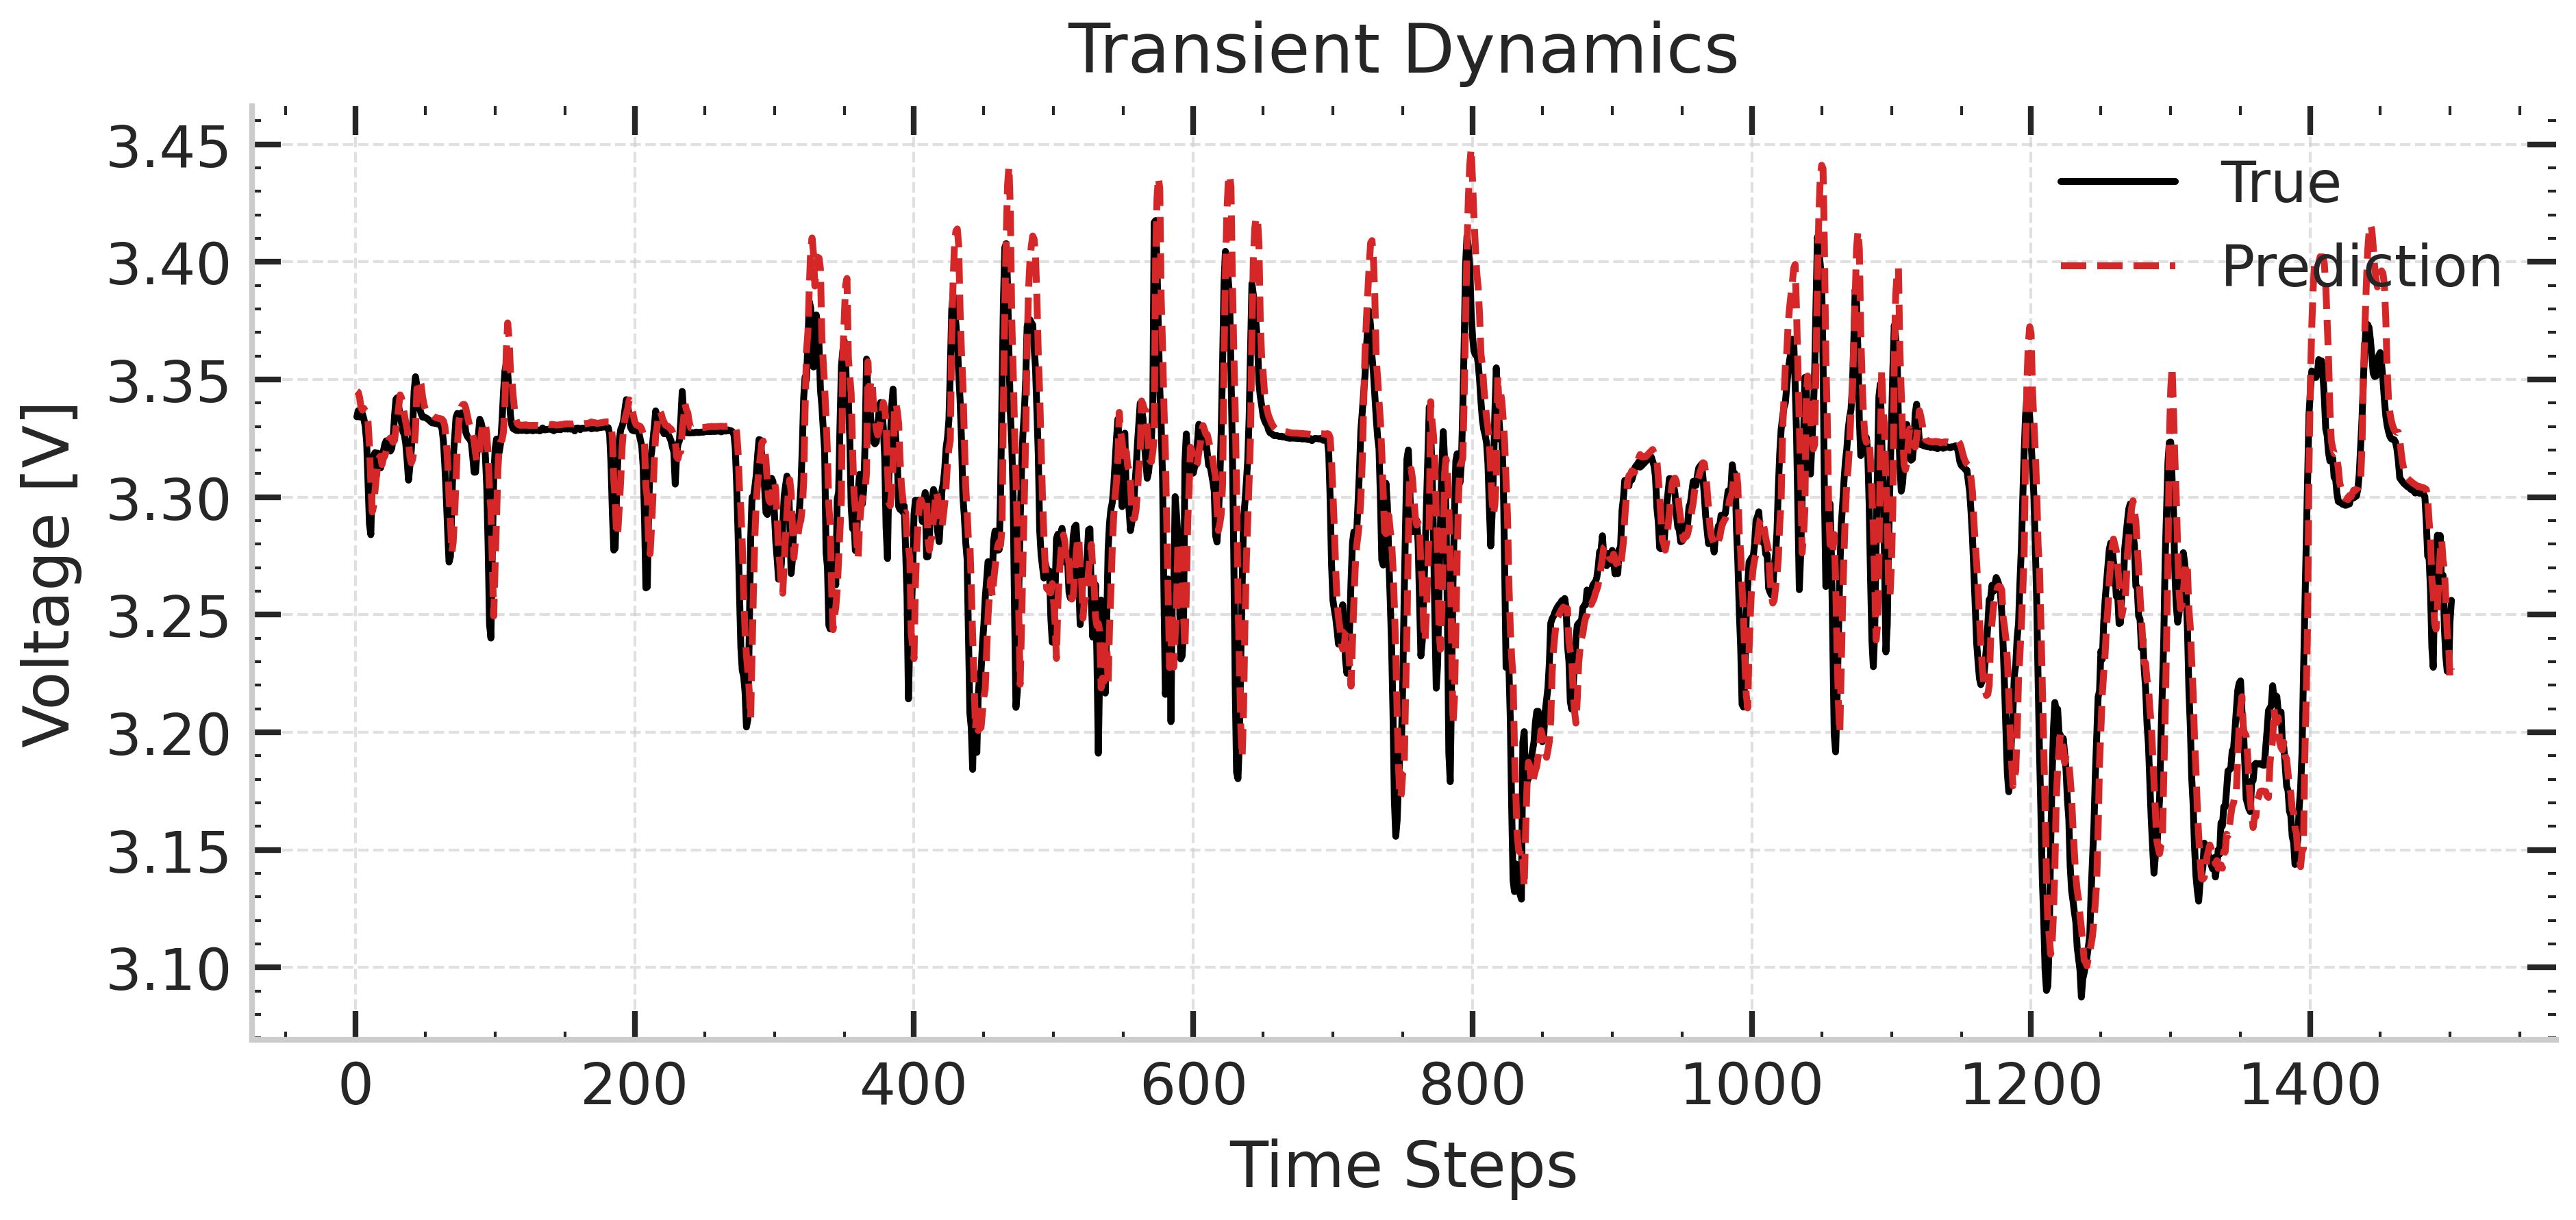

💾 Model saved to: ./Transient_Dynamics_model.pt

🗜️  Created ZIP: koopman_transient.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 Steady State Dynamics Metrics (Indices 62000-66000):
  RMSE   : 0.0183 V
  MAE    : 0.0155 V
  NRMSE  : 0.0545
  R²     : 0.9605


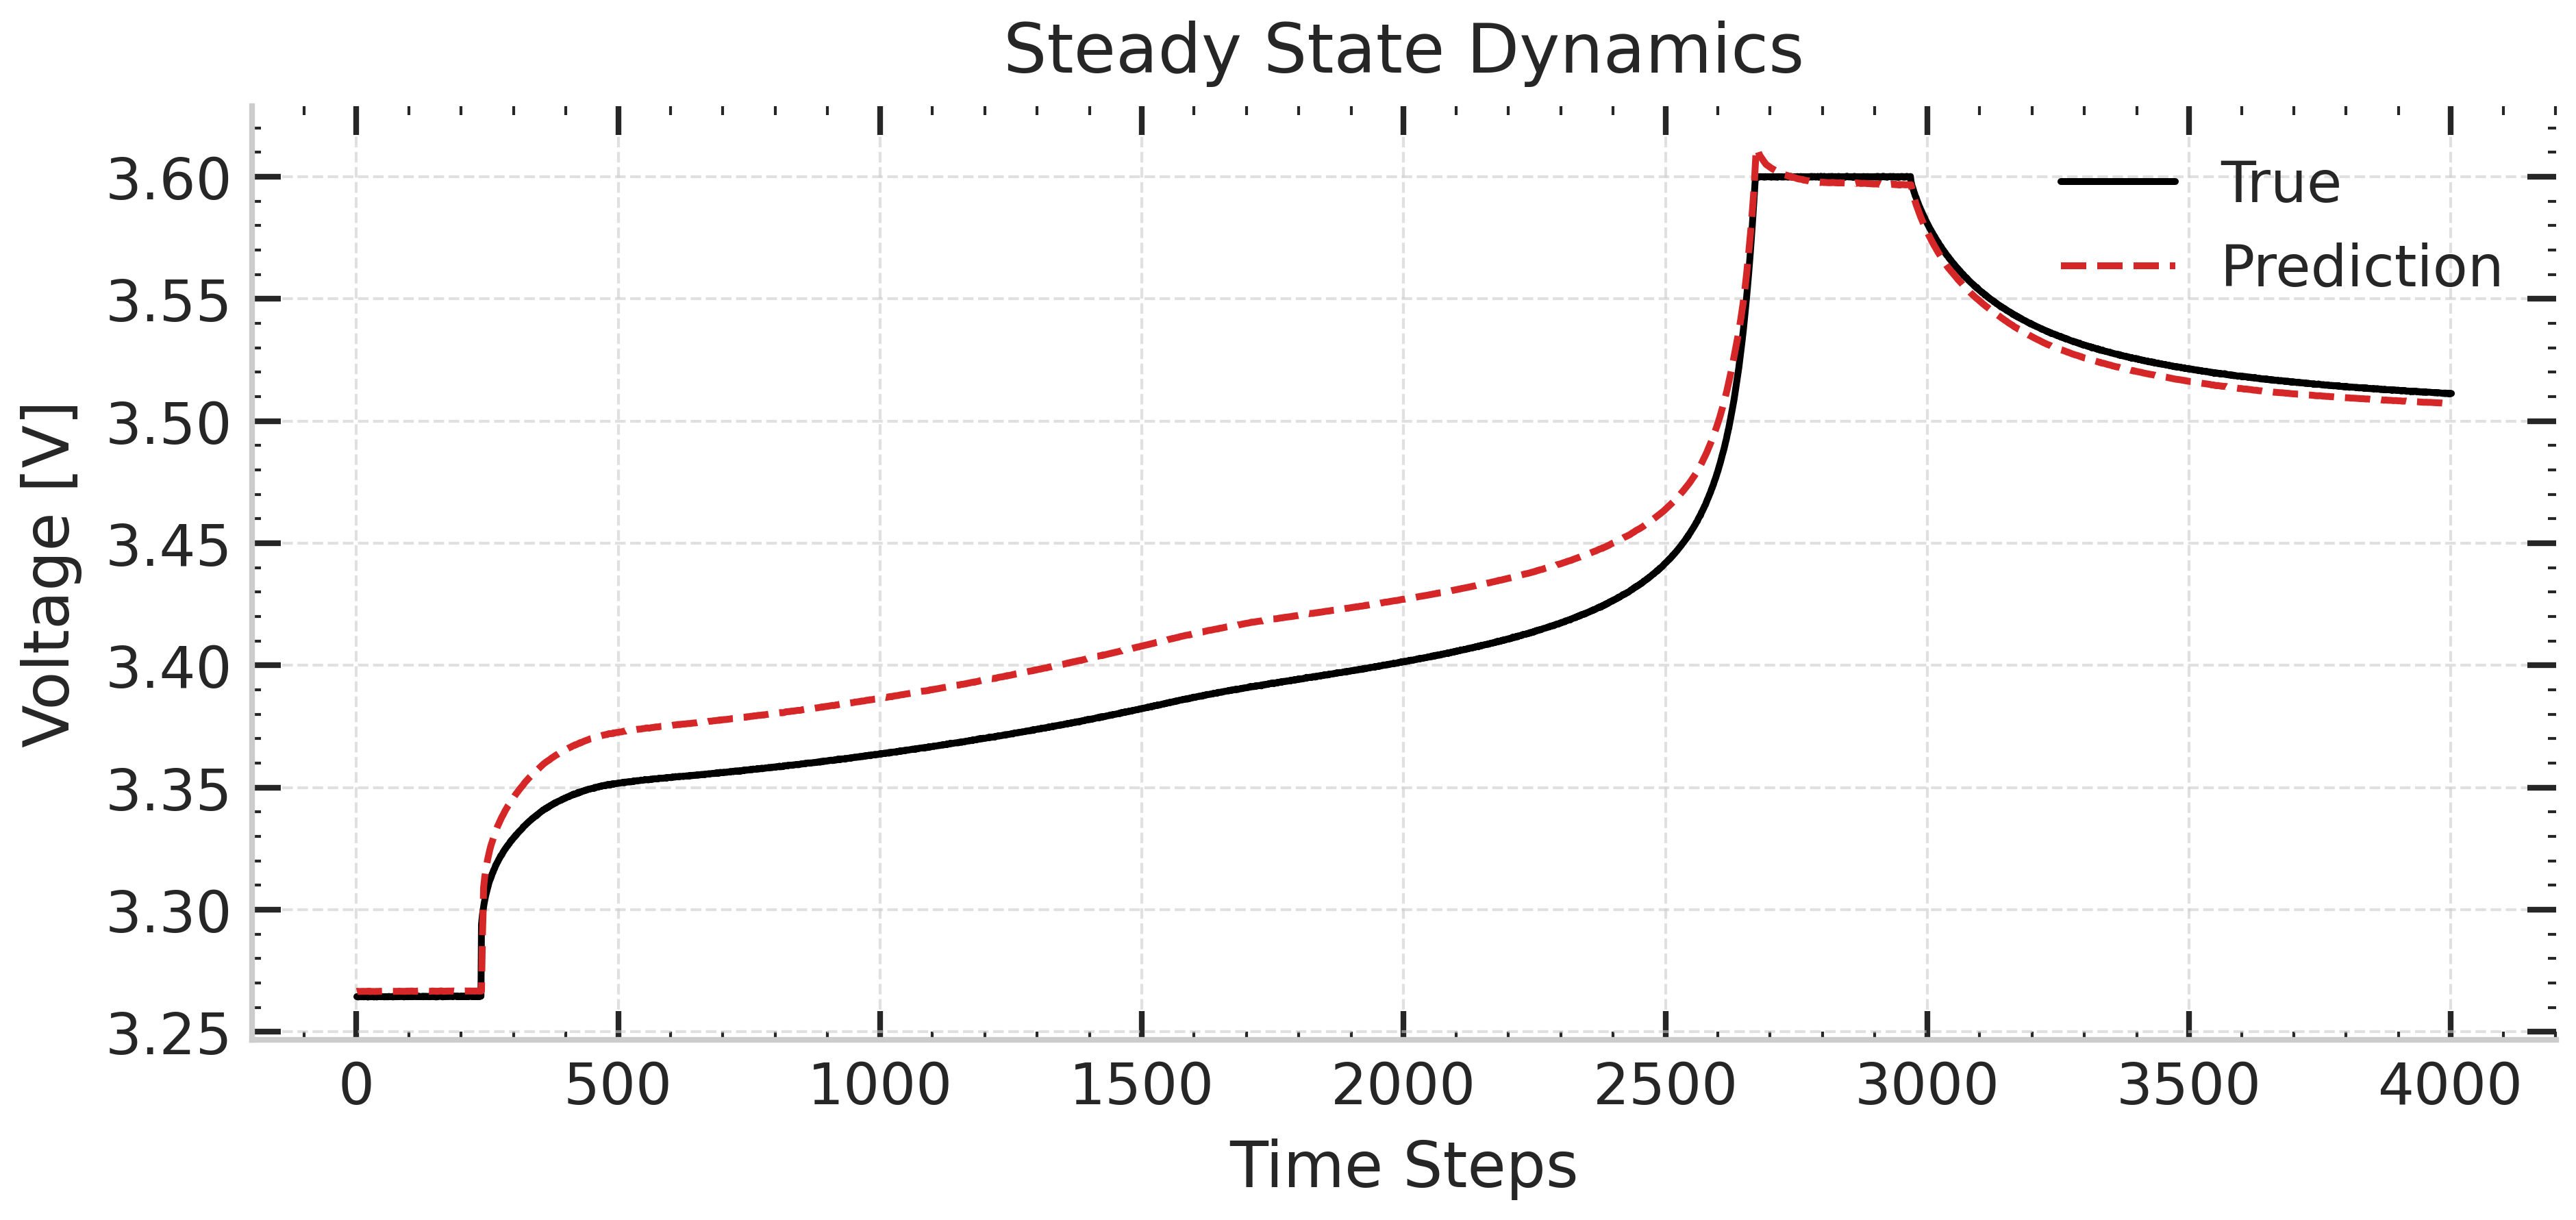

💾 Model saved to: ./Steady_State_Dynamics_model.pt

🗜️  Created ZIP: koopman_SS.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'koopman_SS.zip'

In [192]:
start_time = 72500
end_time = 74000
plot_voltage_denorm_metrics(
    true_voltage=koopman_true,
    preds=koopman_pred,
    region_start_idx=start_time,
    region_end_idx=end_time,
    title_prefix="Transient Dynamics",
    model=model,  # <-- include trained model here
    zip_name="koopman_transient.zip"
)

start_time = 62000
end_time = 66000
plot_voltage_denorm_metrics(
    true_voltage=koopman_true,
    preds=koopman_pred,
    region_start_idx=start_time,
    region_end_idx=end_time,
    title_prefix="Steady State Dynamics",
    model=model,  # <-- include trained model here,
    zip_name="koopman_SS.zip"
)




## LSTM NARX

In [127]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import gc
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ------------------- DEVICE SETUP -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ------------------- LOAD TRAINING DATA -------------------
df_lstm = pd.read_csv("/content/Combined_train_Data.csv").iloc[:10000]
I_lstm = -df_lstm['Current_A'].values.reshape(-1, 1)
V_lstm = df_lstm['Voltage_V'].values.reshape(-1, 1)

# ------------------- FIXED RANGE NORMALIZATION -------------------
scaler_I_lstm = MinMaxScaler()
scaler_V_lstm = MinMaxScaler(feature_range=(-1, 1))
scaler_I_lstm.fit(I_lstm)
scaler_V_lstm.fit([[2.5], [4.3]])

I_lstm_scaled = scaler_I_lstm.transform(I_lstm)
V_lstm_scaled = scaler_V_lstm.transform(V_lstm)

# ------------------- NARX-STYLE INPUTS WITH RESIDUAL -------------------
def create_lstm_narx_sequences(I_seq, V_seq, n_current_delays, n_voltage_delays):
    X, y, v_tm1 = [], [], []
    max_delay = max(n_current_delays, n_voltage_delays)
    for i in range(max_delay, len(I_seq) - 1):
        input_i = []
        input_i.extend(I_seq[i - n_current_delays:i, 0])
        input_i.extend(V_seq[i - n_voltage_delays:i, 0])
        X.append(input_i)
        y.append(V_seq[i + 1])       # true voltage at t
        v_tm1.append(V_seq[i])       # residual V(t-1)
    return np.array(X), np.array(y), np.array(v_tm1)

n_current_delays_lstm = n_current_delays
n_voltage_delays_lstm = n_voltage_delays
input_dim_lstm = n_current_delays_lstm + n_voltage_delays_lstm

X_lstm, y_lstm, V_tm1_lstm = create_lstm_narx_sequences(I_lstm_scaled, V_lstm_scaled,
                                                        n_current_delays_lstm, n_voltage_delays_lstm)
X_lstm = X_lstm.reshape((X_lstm.shape[0], 1, input_dim_lstm))
V_tm1_lstm = V_tm1_lstm.reshape(-1, 1)

# ------------------- MODEL WITH RESIDUAL CONNECTION -------------------
class ResidualNARXLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(ResidualNARXLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, v_tm1):
        out, _ = self.lstm(x)
        residual_pred = self.fc(out[:, -1, :])
        return residual_pred + v_tm1

# ------------------- DATA LOADERS -------------------
X_lstm_tensor = torch.tensor(X_lstm, dtype=torch.float32)
y_lstm_tensor = torch.tensor(y_lstm, dtype=torch.float32)
V_tm1_lstm_tensor = torch.tensor(V_tm1_lstm, dtype=torch.float32)

dataset_lstm = TensorDataset(X_lstm_tensor, V_tm1_lstm_tensor, y_lstm_tensor)
train_size_lstm = int(0.8 * len(dataset_lstm))
val_size_lstm = len(dataset_lstm) - train_size_lstm
train_ds_lstm, val_ds_lstm = random_split(dataset_lstm, [train_size_lstm, val_size_lstm])

train_loader_lstm = DataLoader(train_ds_lstm, batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(val_ds_lstm, batch_size=32)

# ------------------- TRAINING WITH EARLY STOPPING -------------------
model_lstm = ResidualNARXLSTM(input_dim=input_dim_lstm, hidden_dim=16, num_layers=1).to(device)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion_lstm = nn.MSELoss()

patience = 5
best_val_loss = float('inf')
counter = 0
train_losses_lstm = []
val_losses_lstm = []
best_model_state_lstm = None

print("🚀 Starting LSTM Training...\n")
for epoch in range(1000):
    model_lstm.train()
    epoch_loss = 0.0
    for xb, v_tm1b, yb in train_loader_lstm:
        xb, v_tm1b, yb = xb.to(device), v_tm1b.to(device), yb.to(device)
        pred = model_lstm(xb, v_tm1b)
        loss = criterion_lstm(pred, yb)
        optimizer_lstm.zero_grad()
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader_lstm)
    train_losses_lstm.append(epoch_loss)

    model_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, v_tm1b, yb in val_loader_lstm:
            xb, v_tm1b, yb = xb.to(device), v_tm1b.to(device), yb.to(device)
            pred = model_lstm(xb, v_tm1b)
            val_loss += criterion_lstm(pred, yb).item()
    val_loss /= len(val_loader_lstm)
    val_losses_lstm.append(val_loss)

    print(f"Epoch {epoch+1:02d}: Train Loss = {epoch_loss:.6f} | Val Loss = {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state_lstm = model_lstm.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered!")
            break

    gc.collect()
    torch.cuda.empty_cache()

# ------------------- RESTORE BEST MODEL -------------------
model_lstm.load_state_dict(best_model_state_lstm)


✅ Using device: cuda
🚀 Starting LSTM Training...

Epoch 01: Train Loss = 0.004992 | Val Loss = 0.000039
Epoch 02: Train Loss = 0.000028 | Val Loss = 0.000025
Epoch 03: Train Loss = 0.000022 | Val Loss = 0.000023
Epoch 04: Train Loss = 0.000021 | Val Loss = 0.000022
Epoch 05: Train Loss = 0.000019 | Val Loss = 0.000020
Epoch 06: Train Loss = 0.000018 | Val Loss = 0.000018
Epoch 07: Train Loss = 0.000016 | Val Loss = 0.000016
Epoch 08: Train Loss = 0.000014 | Val Loss = 0.000014
Epoch 09: Train Loss = 0.000012 | Val Loss = 0.000012
Epoch 10: Train Loss = 0.000010 | Val Loss = 0.000010
Epoch 11: Train Loss = 0.000009 | Val Loss = 0.000008
Epoch 12: Train Loss = 0.000007 | Val Loss = 0.000007
Epoch 13: Train Loss = 0.000005 | Val Loss = 0.000005
Epoch 14: Train Loss = 0.000004 | Val Loss = 0.000004
Epoch 15: Train Loss = 0.000003 | Val Loss = 0.000003
Epoch 16: Train Loss = 0.000002 | Val Loss = 0.000002
Epoch 17: Train Loss = 0.000001 | Val Loss = 0.000001
Epoch 18: Train Loss = 0.000001 

KeyboardInterrupt: 

🔍 Running LSTM test evaluation...

📊 Test Set Evaluation (Scaled):
  RMSE : 0.021927
  MAE  : 0.020080
  R²   : 0.974385

📊 Test Set Evaluation (Denormalized):
  RMSE : 0.019735 V
  MAE  : 0.018072 V
  R²   : 0.974385


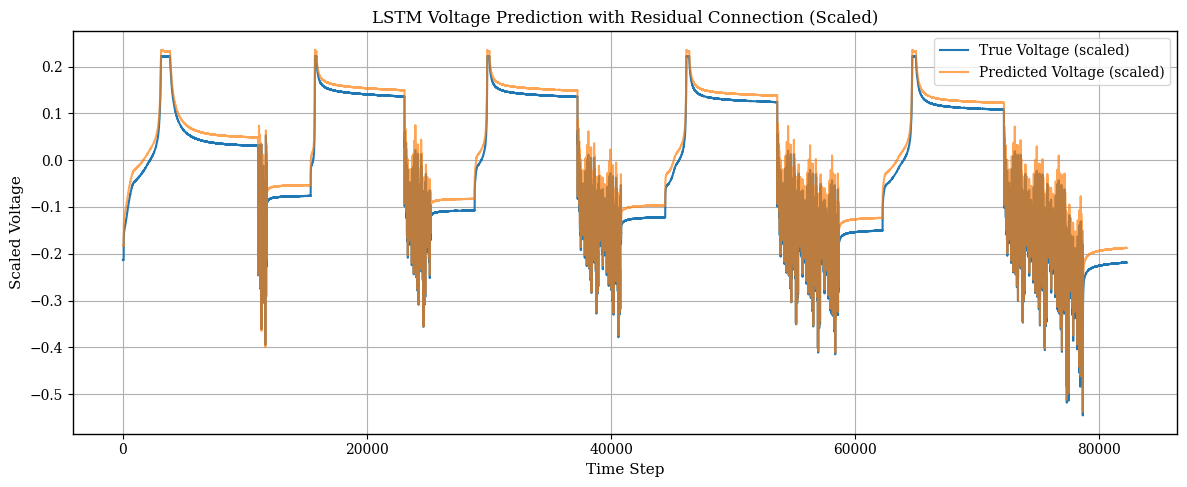

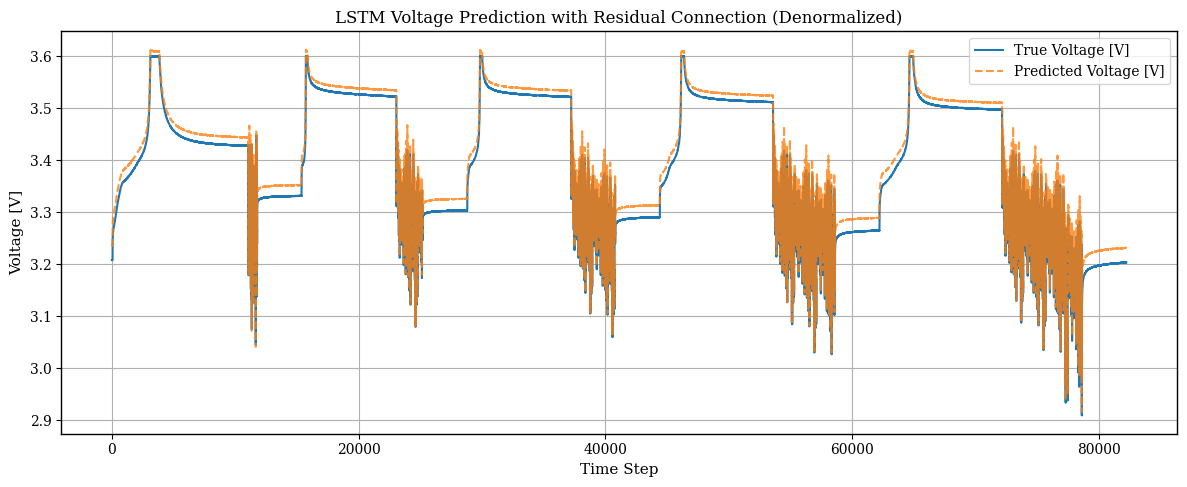

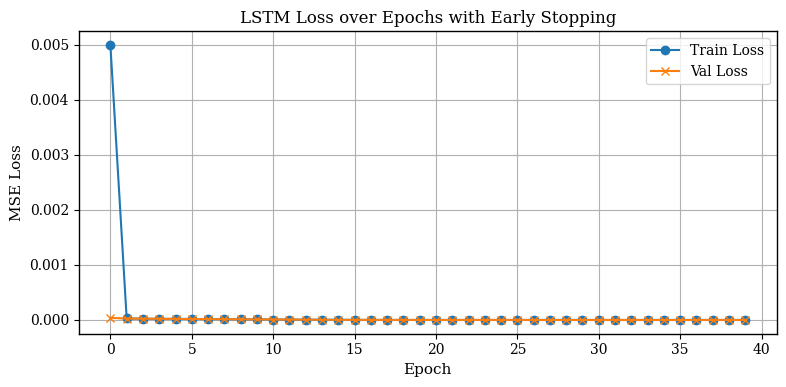

In [128]:
# ------------------- LOAD TEST DATA (LSTM) -------------------
test_df_lstm = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
current_test_lstm = -test_df_lstm['Current_A'].values.reshape(-1, 1)
voltage_test_lstm = test_df_lstm['Voltage_V'].values.reshape(-1, 1)

current_test_scaled_lstm = scaler_I_lstm.transform(current_test_lstm)
voltage_test_scaled_lstm = scaler_V_lstm.transform(voltage_test_lstm)

X_test_lstm, y_test_lstm, V_tm1_test_lstm = create_lstm_narx_sequences(
    current_test_scaled_lstm, voltage_test_scaled_lstm,
    n_current_delays_lstm, n_voltage_delays_lstm
)
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, input_dim_lstm))
V_tm1_test_lstm = V_tm1_test_lstm.reshape(-1, 1)

X_test_tensor_lstm = torch.tensor(X_test_lstm, dtype=torch.float32).to(device)
V_tm1_tensor_lstm = torch.tensor(V_tm1_test_lstm, dtype=torch.float32).to(device)
y_test_tensor_lstm = torch.tensor(y_test_lstm, dtype=torch.float32).to(device)

# ------------------- TEST EVALUATION -------------------
print("🔍 Running LSTM test evaluation...")
model_lstm.eval()
with torch.no_grad():
    pred_scaled_lstm = model_lstm(X_test_tensor_lstm, V_tm1_tensor_lstm).cpu().numpy()
    true_scaled_lstm = y_test_tensor_lstm.cpu().numpy()

# ------------------- METRICS (SCALED) -------------------
rmse_lstm_scaled = np.sqrt(mean_squared_error(true_scaled_lstm, pred_scaled_lstm))
mae_lstm_scaled = mean_absolute_error(true_scaled_lstm, pred_scaled_lstm)
r2_lstm_scaled = r2_score(true_scaled_lstm, pred_scaled_lstm)

print("\n📊 Test Set Evaluation (Scaled):")
print(f"  RMSE : {rmse_lstm_scaled:.6f}")
print(f"  MAE  : {mae_lstm_scaled:.6f}")
print(f"  R²   : {r2_lstm_scaled:.6f}")

# ------------------- DENORMALIZE -------------------
lstm_true = scaler_V_lstm.inverse_transform(true_scaled_lstm)
lstm_pred = scaler_V_lstm.inverse_transform(pred_scaled_lstm)

rmse_lstm = np.sqrt(mean_squared_error(lstm_true, lstm_pred))
mae_lstm = mean_absolute_error(lstm_true, lstm_pred)
r2_lstm = r2_score(lstm_true, lstm_pred)

print("\n📊 Test Set Evaluation (Denormalized):")
print(f"  RMSE : {rmse_lstm:.6f} V")
print(f"  MAE  : {mae_lstm:.6f} V")
print(f"  R²   : {r2_lstm:.6f}")

# ------------------- PLOT PREDICTIONS (SCALED) -------------------
plt.figure(figsize=(12, 5))
plt.plot(true_scaled_lstm, label='True Voltage (scaled)')
plt.plot(pred_scaled_lstm, label='Predicted Voltage (scaled)', alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Scaled Voltage")
plt.title("LSTM Voltage Prediction with Residual Connection (Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- PLOT PREDICTIONS (DENORMALIZED) -------------------
plt.figure(figsize=(12, 5))
plt.plot(lstm_true, label='True Voltage [V]')
plt.plot(lstm_pred, '--', label='Predicted Voltage [V]', alpha=0.8)
plt.xlabel("Time Step")
plt.ylabel("Voltage [V]")
plt.title("LSTM Voltage Prediction with Residual Connection (Denormalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- PLOT LOSS CURVES -------------------
plt.figure(figsize=(8, 4))
plt.plot(train_losses_lstm, label='Train Loss', marker='o')
plt.plot(val_losses_lstm, label='Val Loss', marker='x')
plt.title("LSTM Loss over Epochs with Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📊 Transient Dynamics Metrics (Indices 72500-74000):
  RMSE   : 0.0237 V
  MAE    : 0.0206 V
  NRMSE  : 0.0718
  R²     : 0.8317


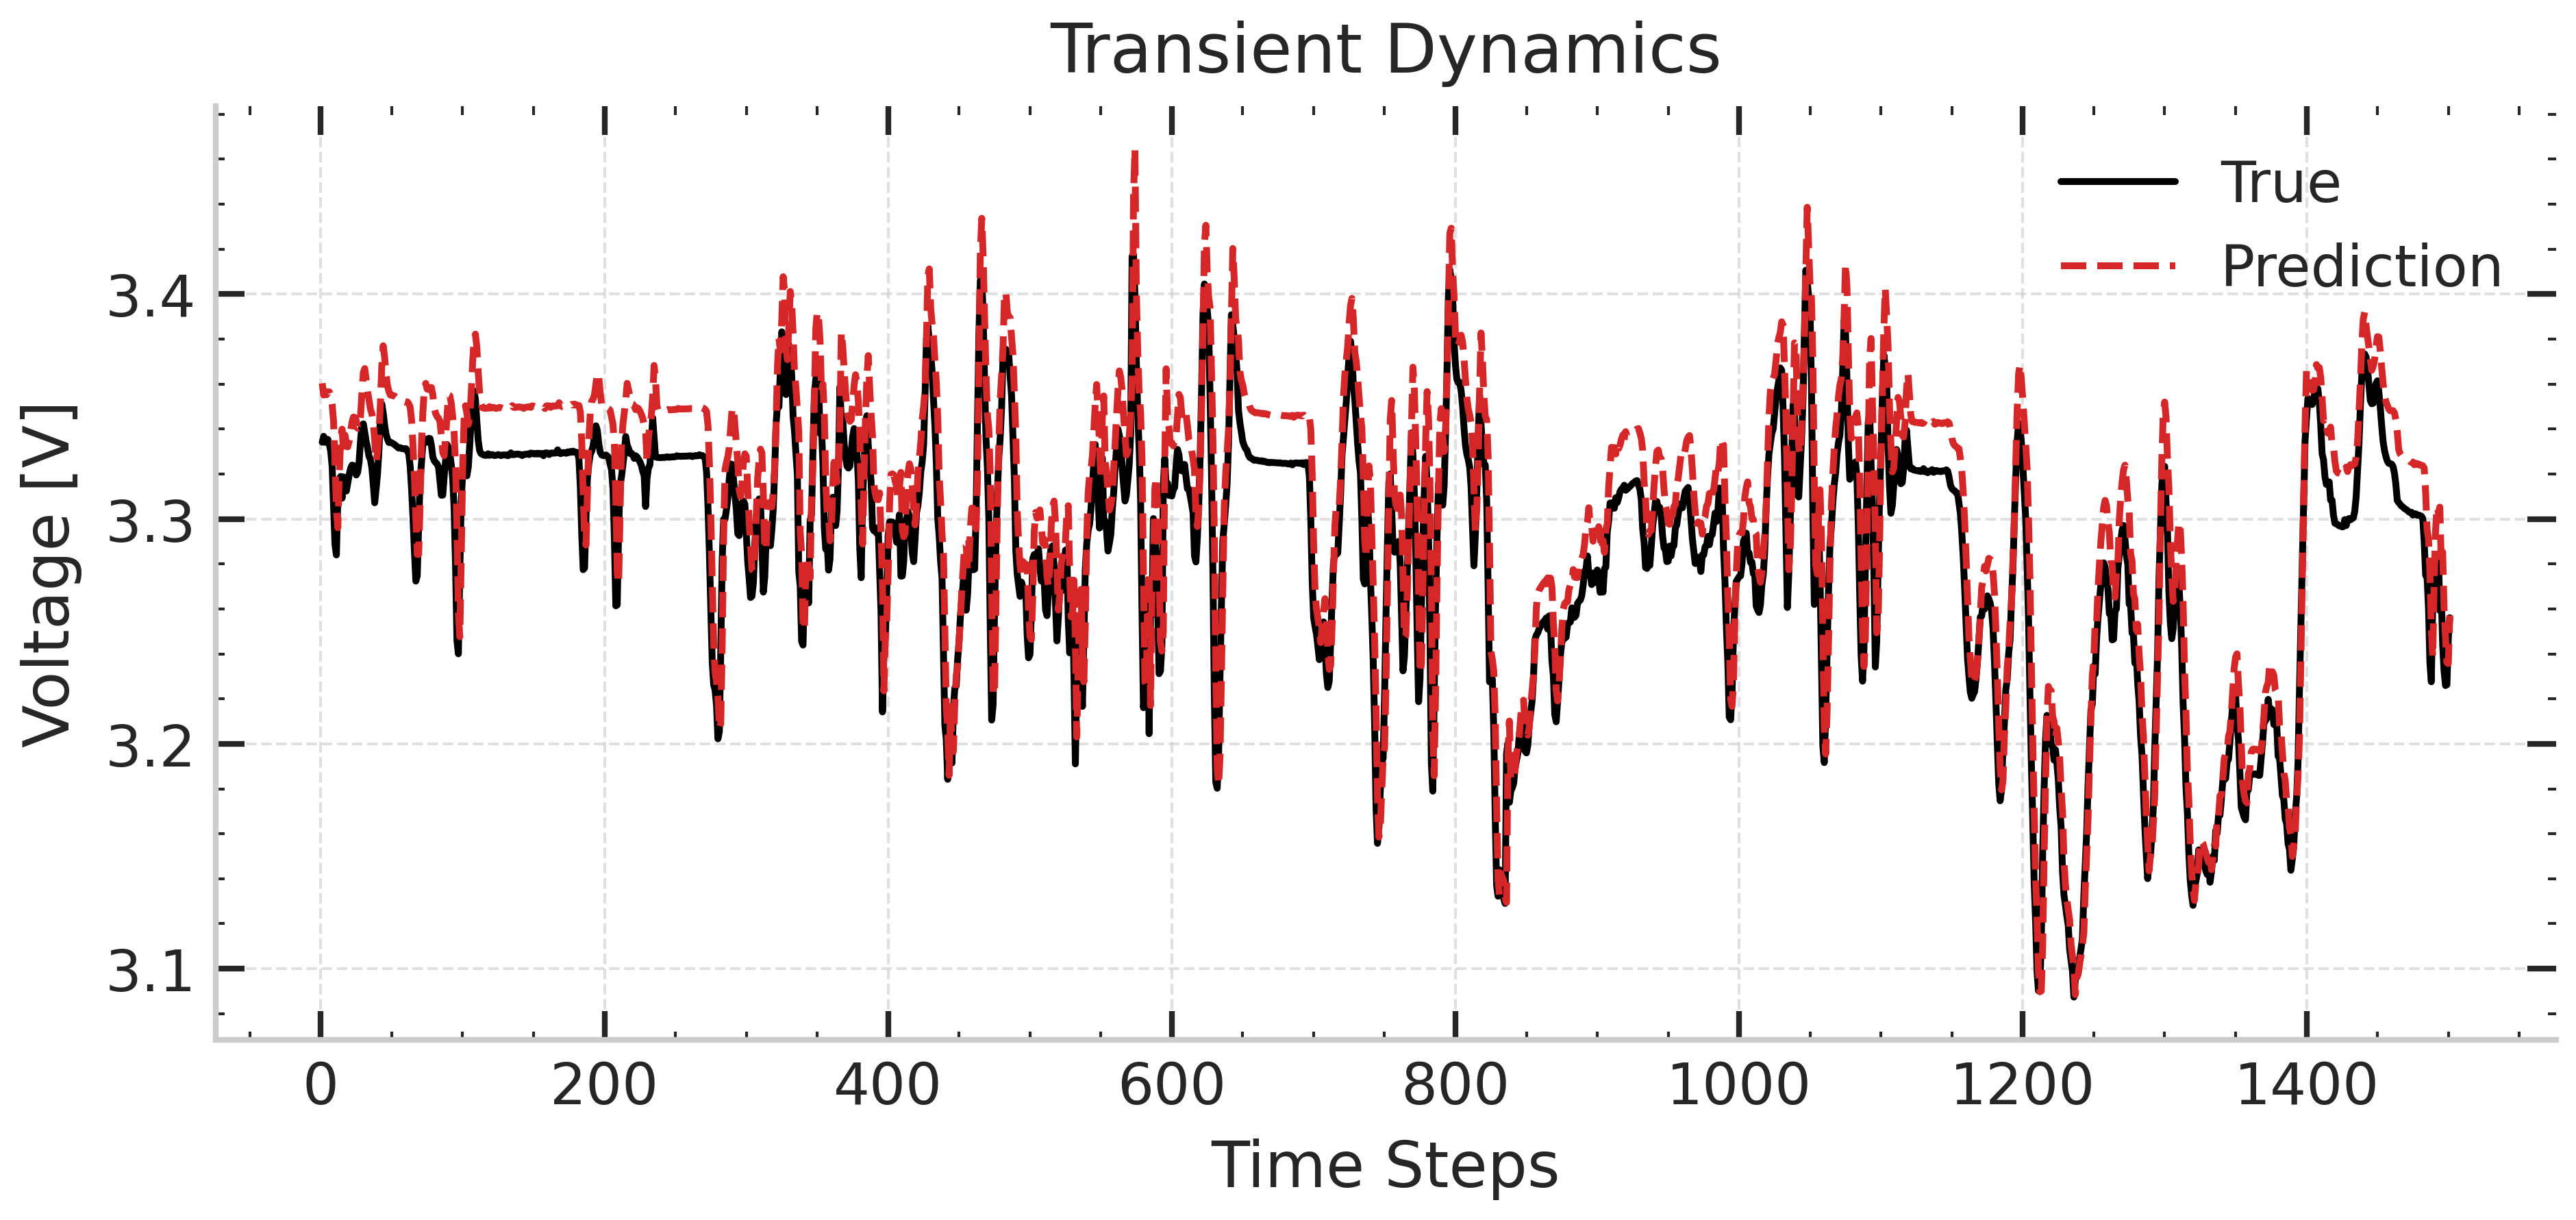

💾 Model saved to: ./Transient_Dynamics_model.pt

🗜️  Created ZIP: LSTM_transient.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 Steady State Dynamics Metrics (Indices 62000-66000):
  RMSE   : 0.0186 V
  MAE    : 0.0179 V
  NRMSE  : 0.0554
  R²     : 0.9591


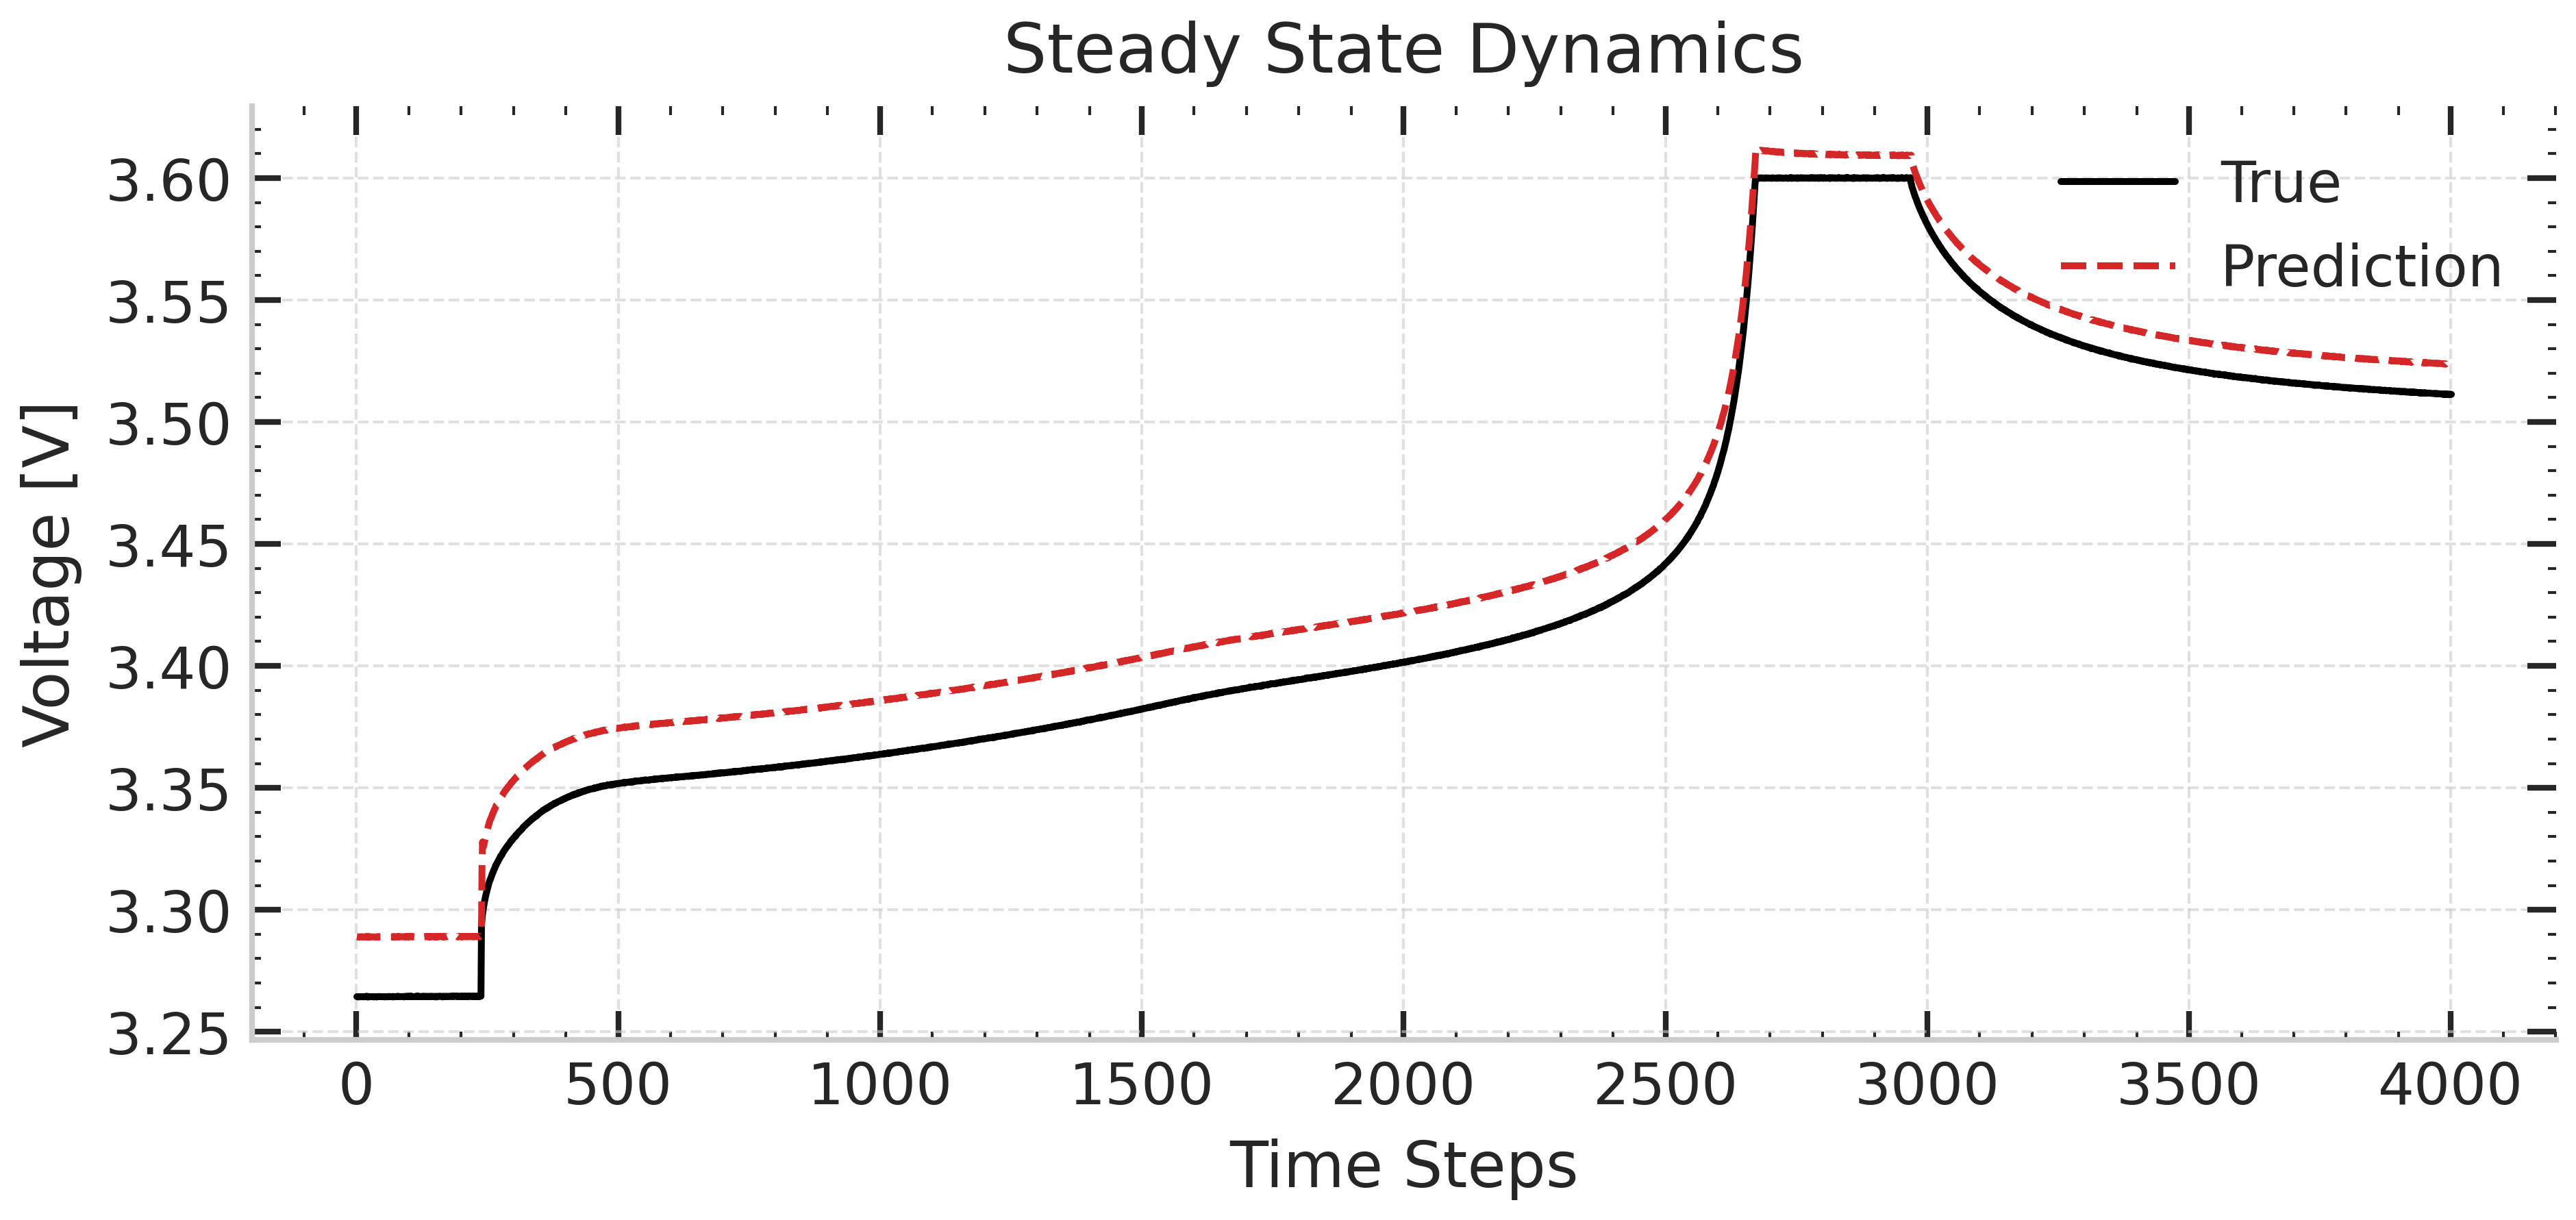

💾 Model saved to: ./Steady_State_Dynamics_model.pt

🗜️  Created ZIP: LSTM_SS.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'LSTM_SS.zip'

In [193]:
start_time = 72500
end_time = 74000
plot_voltage_denorm_metrics(
    true_voltage=lstm_true,
    preds=lstm_pred,
    region_start_idx=start_time,
    region_end_idx=end_time,
    title_prefix="Transient Dynamics",
    model=model,  # <-- include trained model here
    zip_name="LSTM_transient.zip"
)

start_time = 62000
end_time = 66000
plot_voltage_denorm_metrics(
    true_voltage=lstm_true,
    preds=lstm_pred,
    region_start_idx=start_time,
    region_end_idx=end_time,
    title_prefix="Steady State Dynamics",
    model=model,  # <-- include trained model here,
    zip_name="LSTM_SS.zip"
)




In [188]:
def plot_multiple_voltage_predictions(true_voltage, pred_dict, region_start, region_end, title="Voltage Prediction Comparison", filename="multi_model_comparison.pdf", zip_name="multi_model_results.zip",download_zip=True):
    with plt.style.context(['science', 'ieee']):
        plt.rcParams['text.usetex'] = False
        plt.rcParams.update({
            "font.size": 7,
            "axes.labelsize": 7,
            "axes.titlesize": 8,
            "legend.fontsize": 5.5,
            "xtick.labelsize": 6,
            "ytick.labelsize": 6,
            "lines.linewidth": 0.8,
            "lines.markersize": 2.5,
        })

        time_steps = np.arange(1, region_end - region_start + 1)
        fig, ax = plt.subplots(figsize=(3.5, 2.4))

        ax.plot(time_steps, true_voltage[region_start:region_end], label='True Voltage', color='black')

        colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
        linestyles = ['--', '-.', ':', (0, (3, 1, 1, 1))]

        metrics = []

        for i, (label, pred) in enumerate(pred_dict.items()):
            pred_region = pred[region_start:region_end]
            ax.plot(time_steps, pred_region, label=label, linestyle=linestyles[i % len(linestyles)], color=colors[i % len(colors)])

            true_region = true_voltage[region_start:region_end]
            mse = mean_squared_error(true_region, pred_region)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(true_region, pred_region)
            r2 = r2_score(true_region, pred_region)
            nrmse = rmse / (np.max(true_region) - np.min(true_region))

            metrics.append({
                "Model": label,
                "MSE (V²)": mse,
                "RMSE (V)": rmse,
                "MAE (V)": mae,
                "NRMSE": nrmse,
                "R2 Score": r2
            })

        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Voltage [V]")
        ax.set_title(title)
        ax.legend(loc='upper right', frameon=False, fontsize=5.5)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

        # Expand Y-axis range for visual clarity
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min, y_max + 0.1 * (y_max - y_min))

        plt.tight_layout()
        plt.savefig(filename, dpi=600, bbox_inches='tight')
        plt.show()

    metrics_df = pd.DataFrame(metrics)
    metrics_filename = filename.replace(".pdf", "_metrics.xlsx")
    metrics_df.to_excel(metrics_filename, index=False)

    with zipfile.ZipFile(zip_name, 'w') as zipf:
        zipf.write(filename)
        zipf.write(metrics_filename)

    print(f"📄 Saved plot: {filename}")
    print(f"📊 Saved metrics: {metrics_filename}")
    print(f"🗜️  Created ZIP: {zip_name}")
    # Optional download in Colab
    if download_zip:
        try:
            files.download(zip_name)
        except Exception as e:
            print(f"⚠️ Download failed or not in Colab: {e}")

    return zip_name


# PLOT EVERYTHING

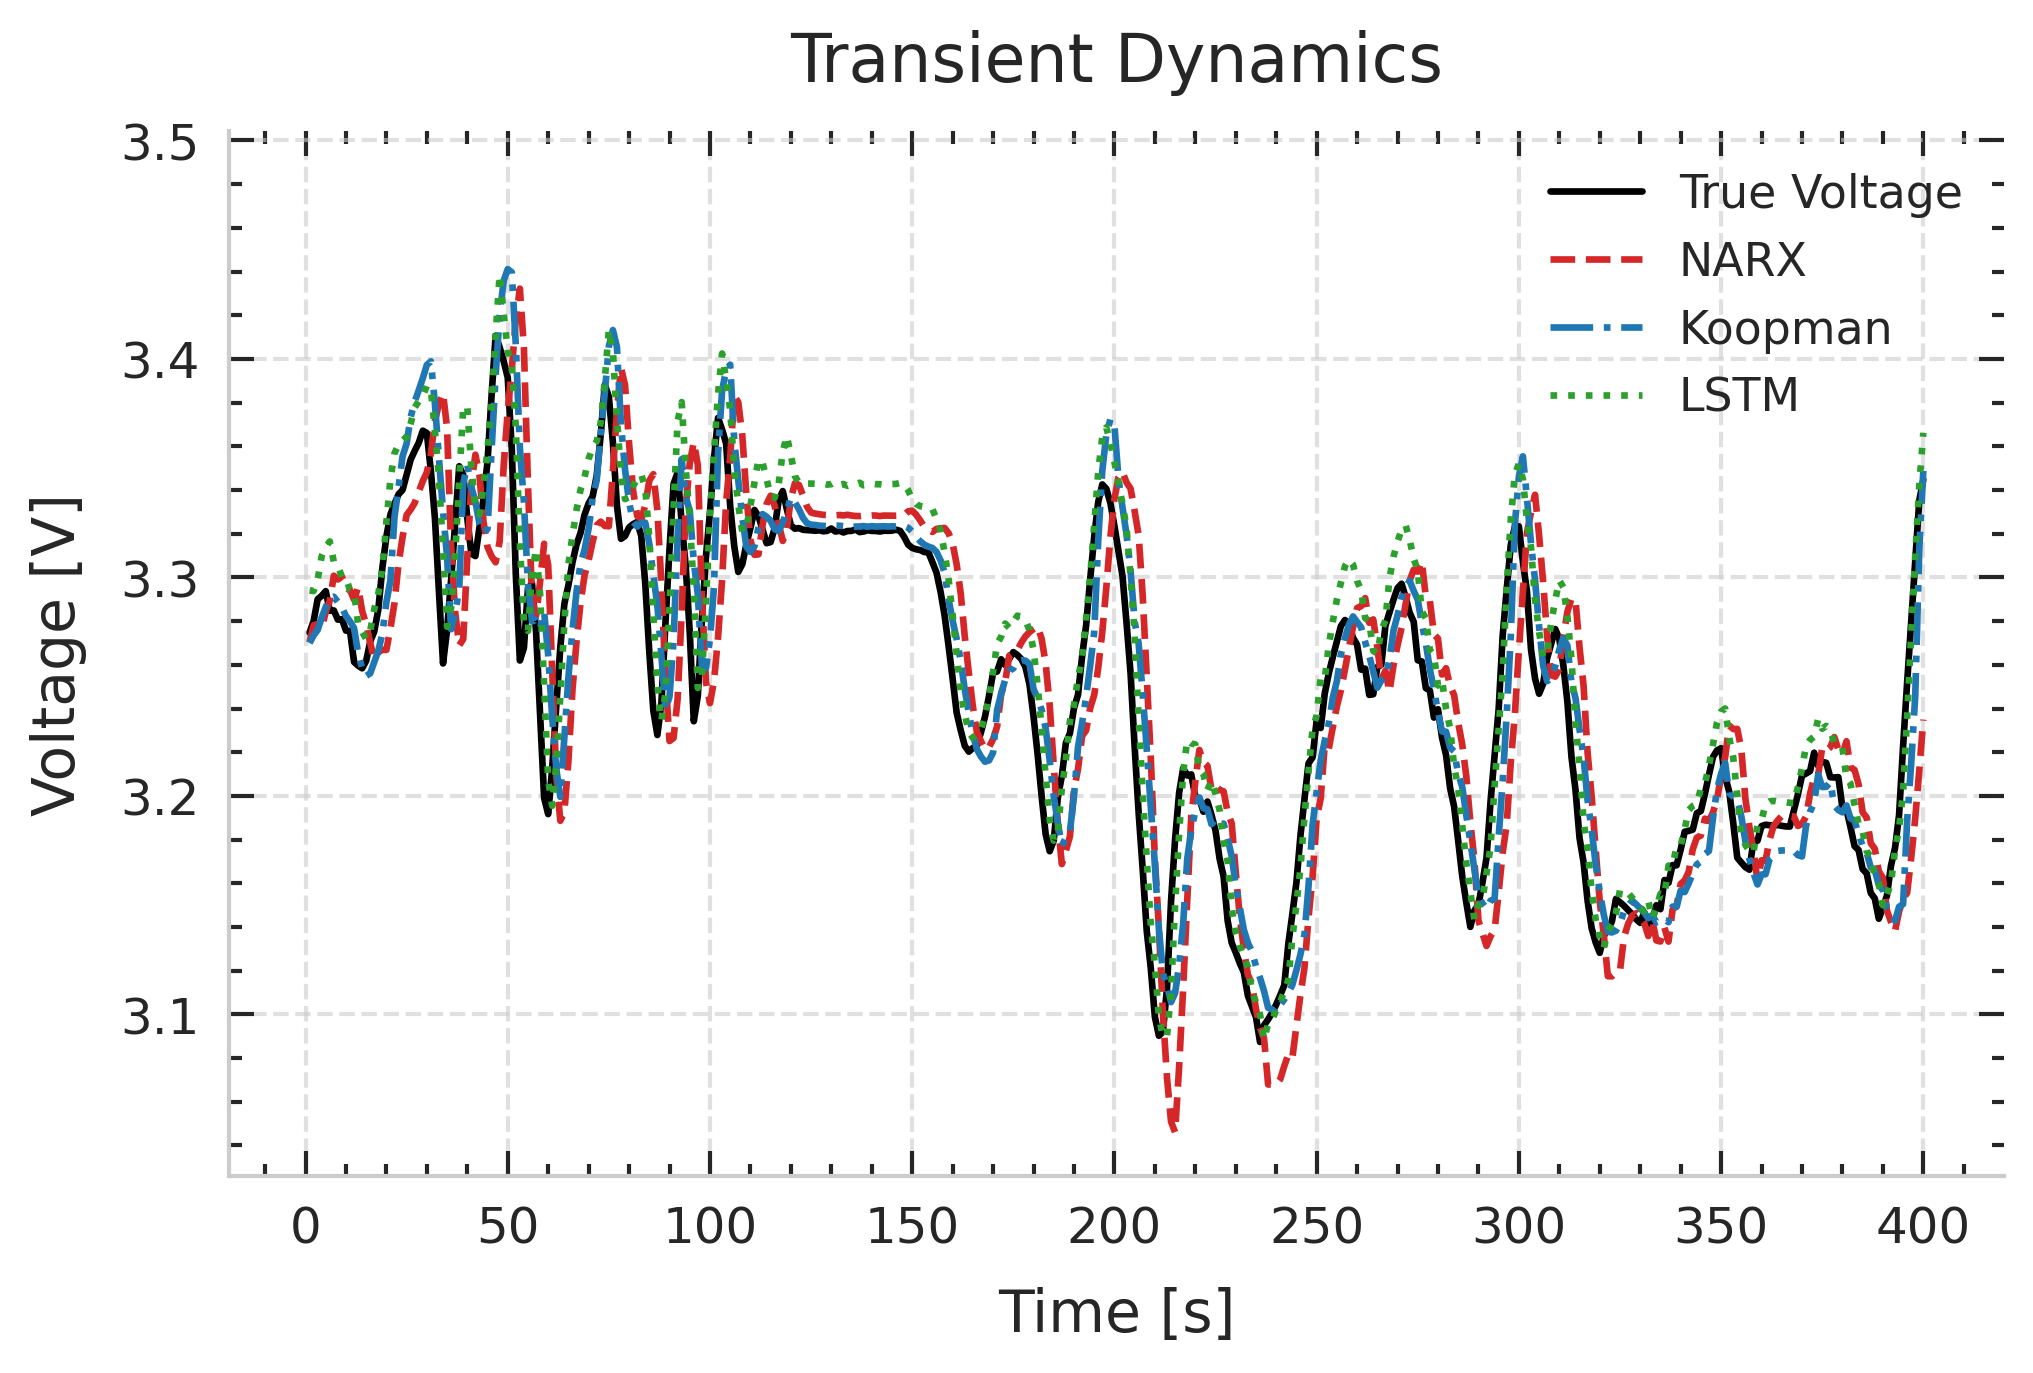

📄 Saved plot: transient_plot.pdf
📊 Saved metrics: transient_plot_metrics.xlsx
🗜️  Created ZIP: transient_bundle.zip


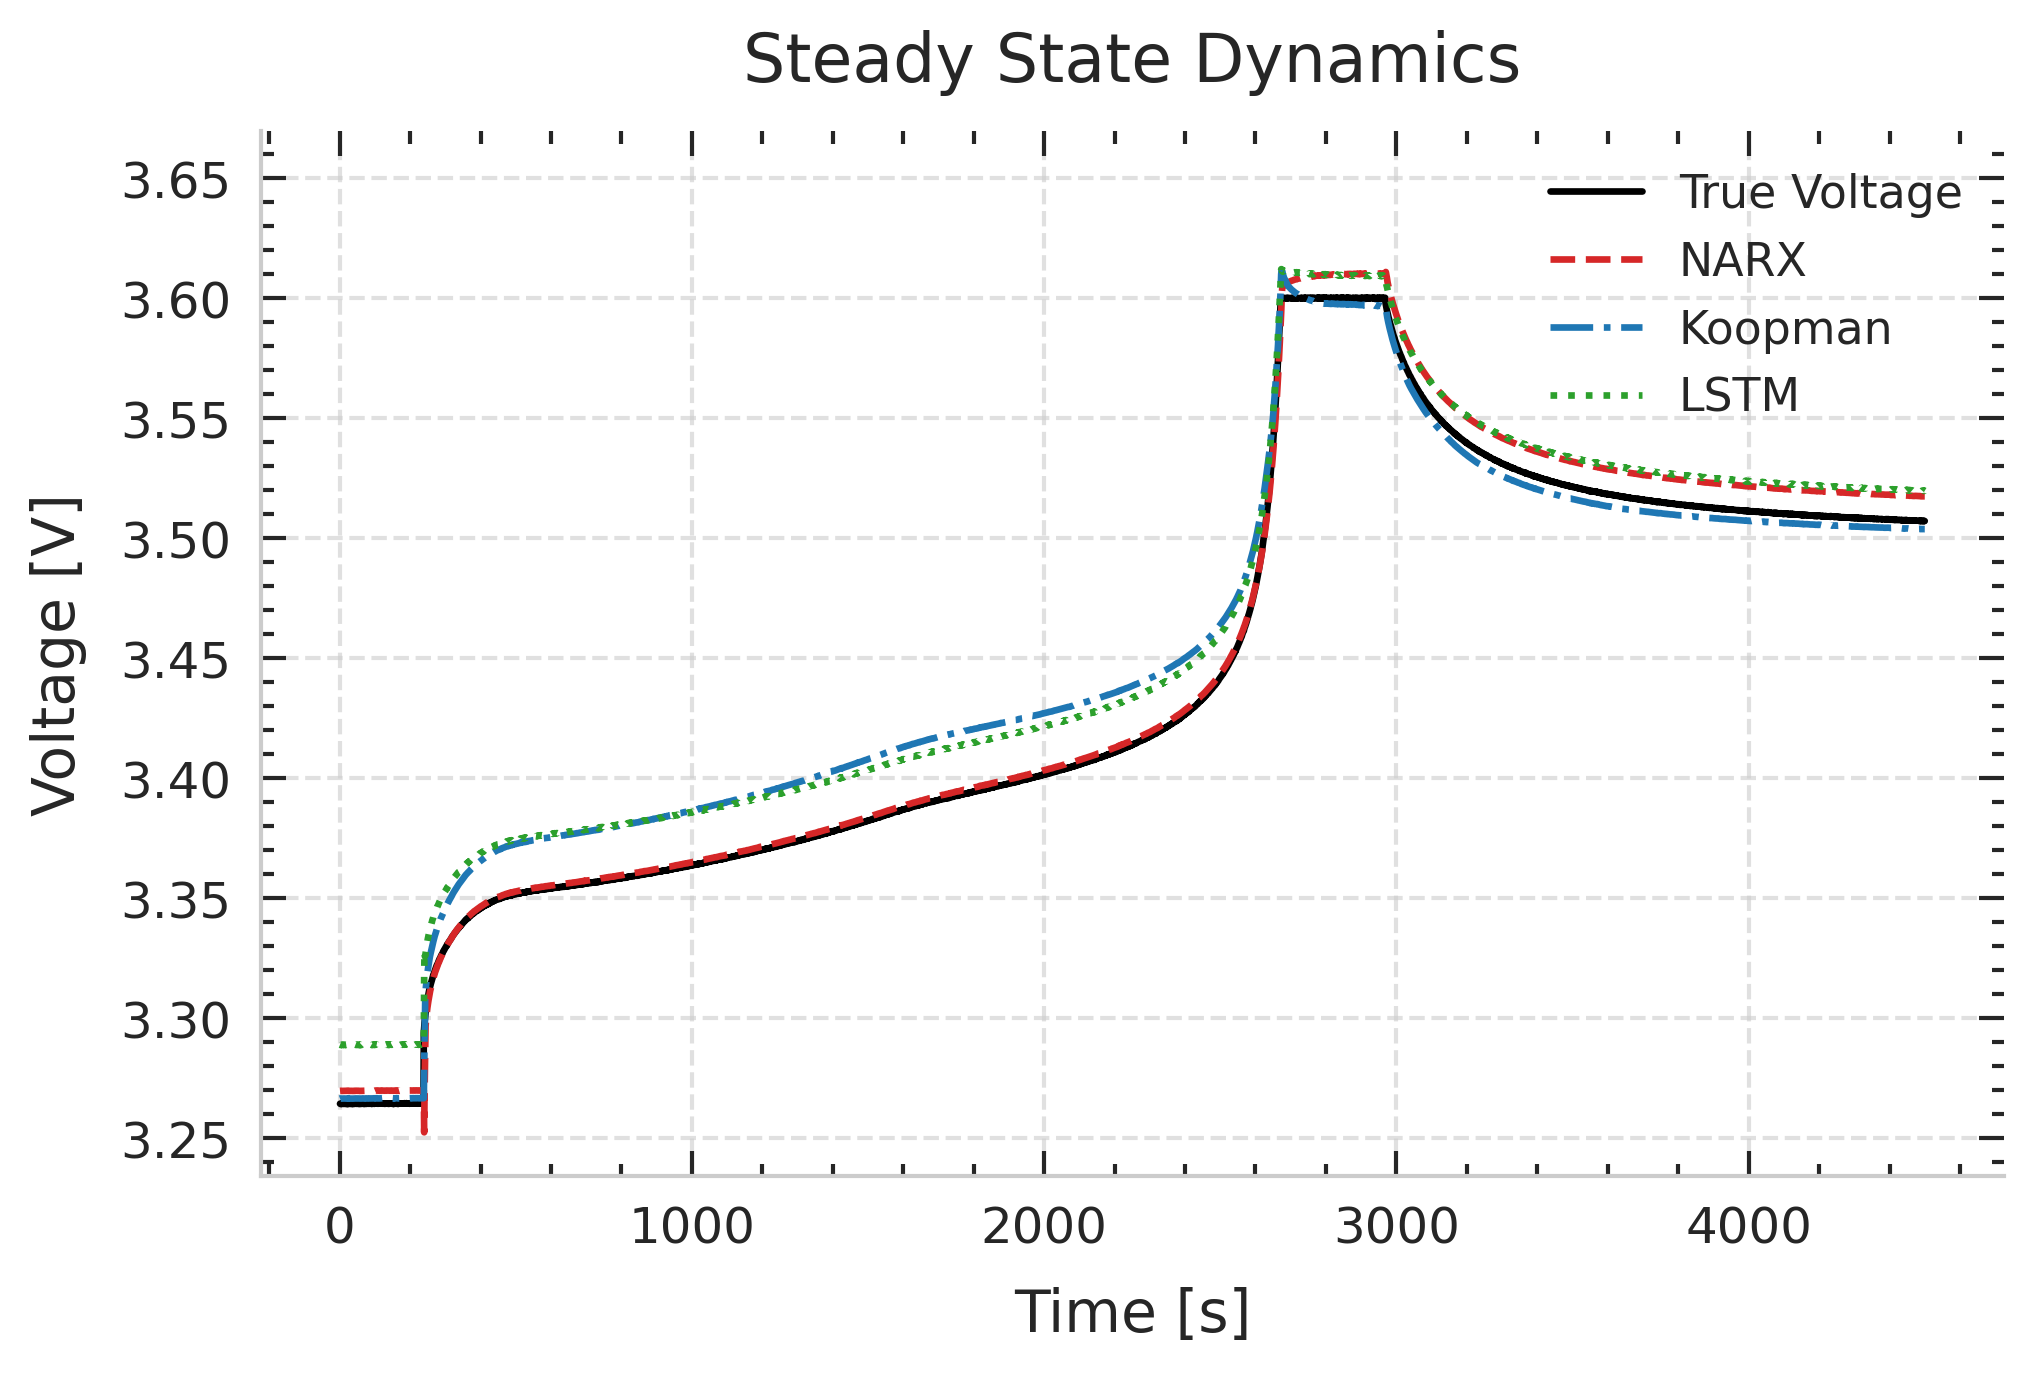

📄 Saved plot: SS_plot.pdf
📊 Saved metrics: SS_plot_metrics.xlsx
🗜️  Created ZIP: SS_bundle.zip


'SS_bundle.zip'

In [189]:
start_time = 73500
end_time = 73900
plot_multiple_voltage_predictions(
    true_voltage=koopman_true,
    pred_dict={
        "NARX": narx_pred,
        "Koopman": koopman_pred,
        "LSTM": lstm_pred
    },
    region_start=start_time,
    region_end=end_time,
    title="Transient Dynamics",
    filename="transient_plot.pdf",
    zip_name="transient_bundle.zip"
)

start_time = 62000
end_time = 66500
plot_multiple_voltage_predictions(
    true_voltage=koopman_true,
    pred_dict={
        "NARX": narx_pred,
        "Koopman": koopman_pred,
        "LSTM": lstm_pred
    },
    region_start=start_time,
    region_end=end_time,
    title="Steady State Dynamics",
    filename="SS_plot.pdf",
    zip_name="SS_bundle.zip"
)
